# Analysis of Traffic Collision Data in Montgomery County, MD 💥🚗

## ✨ Spring 2025 Data Science Project ✨

### Ella Antonishek, Arush Gune, Caden Simpson, Daniel Wang

# 1. Contributions 🤝

Ella worked on the project idea, dataset curation and preprocessing, data exploration and summary statistics, and final tutorial report creation.

Arush worked on the project idea, dataset curation and preprocessing, data exploration through the form of the chi-squared hypothesis test, and the intro and conclusion in the final deliverable.

Caden worked on the project idea, dataset curation and preprocessing, data exploration and summary statistics, visualization, result analysis.

Daniel worked on the project idea, dataset curation and processing, data exploration and summary statistics, machine learning algorithm design/development, machine learning algorithm training and test data analysis, and visualization and result analysis.


1. [Introduction](#Introduction)

2. [Dataset Curation and Preprocessing](#Dataset-Curation-and-Preprocessing)

* i. [Data Preprocessing](#Data-Preprocessing)

* ii. [Outlier Analysis](#Outlier-Analysis)

3. [Exploratory Data Analysis](#Exploratory-Data-Analysis)

* i. [Descriptive Statistics](#Descriptive-Statistics)

* ii. [Hypothesis Testing](#Hypothesis-Testing)

4. [Machine Learning Analysis](#Machine-Learning-Analysis)

* i. [Feature Engineering](#Feature-Engineering)

* ii. [Cluster Analysis](#Cluster-Analysis)

5. [Visualization](#Visualization)

6. [Insights and Conclusions](#Insights-and-Conclusions)

<a name="Introduction"></a>
# 2. Introduction 🤗



According to the National Highway Traffic Safety Administration, there have been an estimated 39,345 traffic fatalities in the United States in 2024.

Traffic accidents are a major public safety concern, causing thousands of injuries and fatalities each year in Maryland alone. Given that motor vehicles are the primary mode of transportation for most Americans, it is important to understand the risk factors associated with driving. This project analyzes Maryland traffic accident data to identify key risk factors that contribute to crashes, such as weather conditions, light levels, speed controls, etc. The main questions we seek to answer are: What are the most common causes of accidents? When and in what situations are accidents most likely to happen? And what patterns emerge that could help predict or prevent future incidents?

Understanding these risk factors is crucial because it empowers both policymakers and the general public to make informed decisions. Targeted safety campaigns, infrastructure improvements, and individual behavior changes all depend on clear, data-backed insights. By educating drivers on the conditions and behaviors that heighten accident risk, this project aims to reduce preventable crashes and ultimately save lives.


<a name="Dataset-Curation-and-Preprocessing"></a>
# 3. Dataset Curation and Preprocessing 📂

For the data collection stage, we will need to find a dataset to analyze. We will be using a dataset on crash reports in Montgomery County, Maryland provided by data.gov (https://catalog.data.gov/dataset/crash-reporting-drivers-data). The data is collected from the Maryland State Police's Automated Crash Reporting System.

This dataset contains over 198 thousand data points with 39 features, allowing us to conduct an in-depth analysis of the potential risk factors.

First, let's import some libraries we will use later. We will also import the dataset from the CSV file online into a dataframe using an API. For more information about the API please see https://docs.ckan.org/en/2.11/api/index.html.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import  f_oneway, tukey_hsd, chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

random_seed = 42

url = "https://data.montgomerycountymd.gov/api/views/mmzv-x632/rows.csv?accessType=DOWNLOAD"
df = pd.read_csv(url, low_memory=False)

Now, we can examine the dataset's number of rows and features, column titles, and data types. This will give us a peak at what our dataset looks like and what it contains.

In [ ]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns {df.shape[1]}')
df.head()

Number of rows: 196043
Number of columns 39


,Report Number,Local Case Number,Agency Name,ACRS Report Type,Crash Date/Time,Route Type,Road Name,Cross-Street Name,Off-Road Description,Municipality,...,Vehicle Going Dir,Speed Limit,Driverless Vehicle,Parked Vehicle,Vehicle Year,Vehicle Make,Vehicle Model,Latitude,Longitude,Location
0,DM8479000T,210020119,Takoma Park Police Depart,Property Damage Crash,05/27/2021 07:40:00 PM,NaN,NaN,NaN,IN PARKING LOT,NaN,...,NaN,0,No,Yes,2017,HINO,TWK,38.987657,-76.987545,"(38.98765667, -76.987545)"
1,MCP2970000R,15045937,MONTGOMERY,Property Damage Crash,09/11/2015 01:29:00 PM,NaN,NaN,NaN,Parking Lot: \n2525 Ennalls Ave,NaN,...,South,5,No,No,2012,TOYOTA,SU,39.039917,-77.053649,"(39.03991652, -77.05364898)"
2,MCP20160036,180040948,Montgomery County Police,Property Damage Crash,08/17/2018 02:25:00 PM,NaN,NaN,NaN,PARKING LOT OF 16246 FREDERICK RD,NaN,...,West,15,No,No,2015,MAZD,TK,38.743373,-77.546997,"(38.743373, -77.54699707)"
3,EJ7879003C,230048975,Gaithersburg Police Depar,Injury Crash,08/11/2023 06:00:00 PM,NaN,NaN,NaN,1 N SUMMIT DRIVE,NaN,...,Unknown,15,No,No,2018,RAM,TK,39.145873,-77.191940,"(39.14587303, -77.19194047)"
4,MCP2967004Y,230070277,Montgomery County Police,Property Damage Crash,12/06/2023 06:42:00 PM,Maryland (State),CONNECTICUT AVE,BALTIMORE ST,NaN,KENSINGTON,...,South,35,No,No,2017,AUDI,A3,39.025170,-77.076333,"(39.02517017, -77.07633333)"


<a name="Data-Preprocessing"></a>
## i. Data Preprocessing

To simplify the analysis, we will only analyze a subset of the dataset's features that are most relevant.

In [ ]:
df = df[['Crash Date/Time', 'Speed Limit', 'Weather', 'Surface Condition',
         'Light', 'Injury Severity', 'Circumstance', 'Traffic Control',
         'Driver Distracted By', 'Vehicle Damage Extent', 'Vehicle Year',
         'Driver Substance Abuse', 'Municipality', 'Route Type']]

For the numeric variables, we can replace any invalid values with NaN.

We can also standardize the formatting for the 'Crash Date/Time' feature.

In [ ]:
df['Speed Limit'] = pd.to_numeric(df['Speed Limit'], errors='coerce')
df['Vehicle Year'] = pd.to_numeric(df['Vehicle Year'], errors='coerce')
df['Crash Date/Time'] = pd.to_datetime(df['Crash Date/Time'], format='%m/%d/%Y %I:%M:%S %p')

Let's replace any blank values with "Unknown".

Then, we will replace any unknown values with NaN. This will make it easier for us to see and handle missing data in later steps.

In [ ]:
df = df.fillna("Unknown")
df.replace(["Unknown", "N/A", "UNKNOWN", "Unknown, Unknown", "nan"], np.nan, inplace=True)

df.head()

,Crash Date/Time,Speed Limit,Weather,Surface Condition,Light,Injury Severity,Circumstance,Traffic Control,Driver Distracted By,Vehicle Damage Extent,Vehicle Year,Driver Substance Abuse,Municipality,Route Type
0,2021-05-27 19:40:00,0,CLEAR,NaN,DAYLIGHT,NO APPARENT INJURY,NaN,NO CONTROLS,NaN,SUPERFICIAL,2017,NONE DETECTED,NaN,NaN
1,2015-09-11 13:29:00,5,CLEAR,NaN,DAYLIGHT,NO APPARENT INJURY,NaN,NO CONTROLS,NaN,NaN,2012,NaN,NaN,NaN
2,2018-08-17 14:25:00,15,CLEAR,NaN,DAYLIGHT,NO APPARENT INJURY,NaN,NaN,NOT DISTRACTED,NO DAMAGE,2015,NaN,NaN,NaN
3,2023-08-11 18:00:00,15,CLEAR,NaN,DAYLIGHT,NO APPARENT INJURY,NaN,NO CONTROLS,NaN,NO DAMAGE,2018,NONE DETECTED,NaN,NaN
4,2023-12-06 18:42:00,35,CLEAR,DRY,DARK LIGHTS ON,NO APPARENT INJURY,NaN,STOP SIGN,NOT DISTRACTED,DISABLING,2017,NaN,KENSINGTON,Maryland (State)


Since many of the categorical variables have values that are formatted inconsistently, let's make all of the text lowercase.



In [ ]:
# Check which features are categorical and which are not.
feature_is_categorical = (df.dtypes == np.dtype('object'))

# Go through each feature.
for feature in df.columns:
  # If the feature is categorical, make all the text lowercase.
  if feature_is_categorical[feature]:
    # Only make it lowercase if the value is not NaN.
    df[feature] = df[feature].apply(lambda val : str(val).lower() if not pd.isna(val) else val)

# Display the modified dataframe.
df.head()

,Crash Date/Time,Speed Limit,Weather,Surface Condition,Light,Injury Severity,Circumstance,Traffic Control,Driver Distracted By,Vehicle Damage Extent,Vehicle Year,Driver Substance Abuse,Municipality,Route Type
0,2021-05-27 19:40:00,0,clear,NaN,daylight,no apparent injury,NaN,no controls,NaN,superficial,2017,none detected,NaN,NaN
1,2015-09-11 13:29:00,5,clear,NaN,daylight,no apparent injury,NaN,no controls,NaN,NaN,2012,NaN,NaN,NaN
2,2018-08-17 14:25:00,15,clear,NaN,daylight,no apparent injury,NaN,NaN,not distracted,no damage,2015,NaN,NaN,NaN
3,2023-08-11 18:00:00,15,clear,NaN,daylight,no apparent injury,NaN,no controls,NaN,no damage,2018,none detected,NaN,NaN
4,2023-12-06 18:42:00,35,clear,dry,dark lights on,no apparent injury,NaN,stop sign,not distracted,disabling,2017,NaN,kensington,maryland (state)


Now, let's examine the percentage of missing values for each variable.

In [ ]:
for feature in df.columns:
  proportion_missing = df[feature].isna().sum() / df.shape[0]

  print(f"Proportion missing for {feature}: {proportion_missing}")

Proportion missing for Crash Date/Time: 0.0
Proportion missing for Speed Limit: 0.0
Proportion missing for Weather: 0.07240758405043791
Proportion missing for Surface Condition: 0.11687231882801222
Proportion missing for Light: 0.011262835194319613
Proportion missing for Injury Severity: 0.007768703804777523
Proportion missing for Circumstance: 0.8091490132266901
Proportion missing for Traffic Control: 0.14227490907607004
Proportion missing for Driver Distracted By: 0.20444494320123646
Proportion missing for Vehicle Damage Extent: 0.035379993164764874
Proportion missing for Vehicle Year: 0.0
Proportion missing for Driver Substance Abuse: 0.23364772014302984
Proportion missing for Municipality: 0.9024397708665955
Proportion missing for Route Type: 0.09780507337675919


Since 'Light', 'Injury Severity', 'Vehicle Damage Extent', and 'Traffic Control' each have a small percentage of missing values (<5\%), we will drop the rows with missing values in those columns.

Since the majority of values for the 'Circumstance' and 'Municipality' columns are missing, we will also drop those columns.

In [ ]:
# Get the original size of the dataset.
old_num_rows = df.shape[0]

# Drop the rows with missing values for these columns.
df = df.dropna(subset=['Light', 'Injury Severity', 'Vehicle Damage Extent','Traffic Control'])
# Drop the 'Circumstance' and 'Municipality' columns.
df = df.drop(columns=['Circumstance', 'Municipality'], axis=1)

# Get the new size of the dataset.
new_num_rows = df.shape[0]

# Check how many of the original values we deleted.
print("New dataset size relative to old size:", new_num_rows / old_num_rows)

New dataset size relative to old size: 0.8178562866309942


We will need to reset the dataframe's indices after dropping the rows with missing values.

Given the number of missing values in certain columns, we can impute the missing data using the modes of each column.

In [ ]:
df = df.reset_index(drop=True)
df['Weather'] = df['Weather'].fillna(df['Weather'].mode()[0])
df['Surface Condition'] = df['Surface Condition'].fillna(df['Surface Condition'].mode()[0])
df['Traffic Control'] = df['Traffic Control'].fillna(df['Traffic Control'].mode()[0])
df['Driver Distracted By'] = df['Driver Distracted By'].fillna(df['Driver Distracted By'].mode()[0])
df['Driver Substance Abuse'] = df['Driver Substance Abuse'].fillna(df['Driver Substance Abuse'].mode()[0])
df['Route Type'] = df['Route Type'].fillna(df['Route Type'].mode()[0])

Now, let's take a look at the 'Weather' variable.

In [ ]:
df['Weather'].value_counts()

,count
Weather,
clear,121474
raining,17300
cloudy,16194
rain,2260
snow,1382
foggy,561
wintry mix,300
other,281
sleet,169


Since there are so many possible values for weather in the dataset, we will combine some of the similar types of weather into common categories.

To accomplish this, we will use the pandas map() function (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html). The map function appplies a function to all of the data and it is very fast, which is highly useful for a large dataset like our.

In [ ]:
weather_mapping = { 'clear' : 'Clear',
                    'cloudy' : 'Cloudy',
                    'raining' : 'Rain',
                    'rain' : 'Rain',
                    'severe winds' : 'Wind',
                    'severe crosswinds' : 'Wind',
                    'foggy' : 'Fog',
                    'fog, smog, smoke' : 'Fog',
                    'snow' : 'Snow',
                    'blowing snow' : 'Snow',
                    'wintry mix' : 'Wintry Mix',
                    'sleet' : 'Wintry Mix',
                    'freezing rain or freezing drizzle' : 'Wintry Mix',
                    'sleet or hail' : 'Wintry Mix',
                    'other' : 'Other',
                    'blowing sand, soil, dirt' : 'Other' }

df['Weather'] = df['Weather'].str.lower().map(weather_mapping)

We will do the same for the 'Vehicle Damage Extent' variable. Let's capitalize everything for consistency.

In [ ]:
vehicle_damage_mapping = {
    'disabling': 'Disabling',
    'functional': 'Functional',
    'superficial': 'Superficial',
    'destroyed': 'Destroyed',
    'no damage': 'No Damage',
    'vehicle not at scene': 'Vehicle Not At Scene',
    'other': 'Other'
}

df['Vehicle Damage Extent'] = df['Vehicle Damage Extent'].map(vehicle_damage_mapping)

df['Vehicle Damage Extent'].value_counts()

,count
Vehicle Damage Extent,
Disabling,64347
Functional,42899
Superficial,40857
Destroyed,6474
No Damage,5249
Vehicle Not At Scene,434
Other,75


Now we will also examine the 'Injury Severity' variable and combine similar types.

In [ ]:
injury_mapping = {
    'no apparent injury': 'No Apparent Injury',
    'possible injury': 'Minor Injury',
    'suspected minor injury': 'Minor Injury',
    'suspected serious injury': 'Serious Injury',
    'fatal injury': 'Fatal Injury'
}

df['Injury Severity'] = df['Injury Severity'].map(injury_mapping)

df['Injury Severity'].value_counts()

,count
Injury Severity,
No Apparent Injury,129608
Minor Injury,29177
Serious Injury,1414
Fatal Injury,136


Now we will take a look at the 'Light' Variable, combining similar light conditions.

In [ ]:
df = df[df['Light'] != 'other']
light_mapping = { 'daylight': 'Daylight',
                  'dusk': 'Low Light',
                  'dawn': 'Low Light',
                  'dark lights on': 'Low Light',
                  'dark - lighted': 'Low Light',
                  'dark no lights': 'Dark',
                  'dark - not lighted': 'Dark',
                  'other': 'Other'
                }

df.loc[:, 'Light'] = df['Light'].map(light_mapping)

df['Light'].value_counts()

,count
Light,
Daylight,109976
Low Light,44087
Dark,4684


We can repeat this process for the rest of the categorical variables.

In [ ]:
surface_condition_mapping = {'dry': 'Dry',
                             'wet': 'Wet',
                             'snow': 'Snow',
                             'ice': 'Ice',
                             'slush': 'Snow',
                             'other': 'Other',
                             'ice/frost': 'Ice',
                             'mud, dirt, gravel': 'Other',
                             'water(standing/moving)': 'Wet',
                             'oil': 'Other',
                             'water (standing, moving)': 'Wet',
                             'sand': 'Other'
                            }

df.loc[:, 'Surface Condition'] = df['Surface Condition'].map(surface_condition_mapping)

df['Surface Condition'].value_counts()

,count
Surface Condition,
Dry,130318
Wet,27391
Snow,1141
Ice,943
Other,232


In [ ]:
driver_distracted_by_mapping = {'not distracted': 'Not Distracted',
                                'looked but did not see': 'Inattention',
                                'inattentive or lost in thought': 'Inattention',
                                'other distraction': 'Other',
                                'distracted by outside person object or event': 'External Distraction',
                                'other action (looking away from task, etc.)': 'Inattention',
                                'by other occupants': 'External Distraction',
                                'other cellular phone related': 'Phone Distraction',
                                'other electronic device (navigational palm pilot)': 'Device Distraction',
                                'talking or listening to cellular phone': 'Phone Distraction',
                                'by moving object in vehicle': 'External Distraction',
                                'eating or drinking': 'Eating, Drinking, Smoking',
                                'no driver present': 'Not Distracted',
                                'adjusting audio and or climate controls': 'Device Distraction',
                                'using other device controls integral to vehicle': 'Device Distraction',
                                'using device object brought into vehicle': 'Device Distraction',
                                'texting from a cellular phone': 'Phone Distraction',
                                'dialing cellular phone': 'Phone Distraction',
                                'talking/listening': 'Inattention',
                                'manually operating (dialing, playing game, etc.)': 'Other',
                                'smoking related': 'Eating, Drinking, Smoking'
                               }

df.loc[:,'Driver Distracted By'] = df['Driver Distracted By'].map(driver_distracted_by_mapping)

df['Driver Distracted By'].value_counts()

,count
Driver Distracted By,
Not Distracted,132171
Inattention,22635
Other,2590
External Distraction,1314
Phone Distraction,611
Device Distraction,518
"Eating, Drinking, Smoking",186


In [ ]:
substance_abuse_mapping = {
                            'none detected': 'None',
                            'not suspect of alcohol use, not suspect of drug use': 'None',
                            'alcohol present': 'Alcohol',
                            'alcohol contributed': 'Alcohol',
                            'suspect of alcohol use, not suspect of drug use': 'Alcohol',
                            'illegal drug present': 'Drug',
                            'medication present': 'Medication',
                            'illegal drug contributed': 'Drug',
                            'combined substance present': 'Drug & Alcohol',
                            'suspect of alcohol use, unknown': 'Unknown',
                            'medication contributed': 'Medication',
                            'unknown, not suspect of drug use': 'Unknown',
                            'combination contributed': 'Drug & Alcohol',
                            'other': 'Other',
                            'suspect of alcohol use, suspect of drug use': 'Unknown',
                            'not suspect of alcohol use, suspect of drug use': 'Unknown',
                            'not suspect of alcohol use, unknown': 'Unknown',
                            'unknown, suspect of drug use': 'Unknown'
                          }

df['Driver Substance Abuse'] = df['Driver Substance Abuse'].map(substance_abuse_mapping)

df['Driver Substance Abuse'].value_counts()

,count
Driver Substance Abuse,
None,154273
Alcohol,4962
Drug,293
Unknown,211
Medication,143
Drug & Alcohol,109
Other,34


In [ ]:
route_type_mapping = {
                      'maryland (state)': 'Government-Owned Public Roads',
                      'county': 'Government-Owned Public Roads',
                      'municipality': 'Local Roads',
                      'county route': 'Government-Owned Public Roads',
                      'us (state)': 'Government-Owned Public Roads',
                      'maryland (state) route': 'Government-Owned Public Roads',
                      'interstate (state)': 'Government-Owned Public Roads',
                      'municipality route': 'Local Roads',
                      'other public roadway': 'Other',
                      'ramp': 'Other',
                      'government': 'Private',
                      'local route': 'Local Roads',
                      'bicycle route': 'Other',
                      'spur': 'Other',
                      'private route': 'Private',
                      'crossover': 'Other',
                      'government route': 'Private',
                      'service road': 'Other'
                     }

df['Route Type'] = df['Route Type'].map(route_type_mapping)

df['Route Type'].value_counts()

,count
Route Type,
Government-Owned Public Roads,146767
Local Roads,9754
Other,2751
Private,753


In [ ]:
traffic_control_mapping = {'no controls' : 'No Controls',
                           'traffic signal' : 'Traffic Signal',
                           'stop sign' : 'Stop Sign',
                           'traffic control signal' : 'Traffic Signal',
                           'flashing traffic signal' : 'Flashing Traffic Signal',
                           'other' : 'Other',
                           'yield sign' : 'Stop Sign',
                           'flashing traffic control signal' : 'Flashing Traffic Signal',
                           'person' : 'Other',
                           'warning sign' : 'Other',
                           'lane use control signal' : 'Other',
                           'pedestrian crossing sign' : 'Other',
                           'pedestrian crossing' : 'Other',
                           'other pavement marking (excluding edgelines, centerlines, or lane lines)' : 'Other',
                           'other signal' : 'Other',
                           'railway crossing device' : 'Other',
                           'other warning sign' : 'Other',
                           'person (including flagger, law enforcement, crossing guard, etc.' : 'Other',
                           'school zone sign device' : 'Other',
                           'intersection ahead warning sign' : 'Other',
                           'curve ahead warning sign' : 'Other',
                           'reduce speed ahead warning sign' : 'Other',
                           'school zone sign' : 'Other',
                           'ramp meter signal' : 'Other',
                           'flashing railroad crossing signal (may include gates)' : 'Other',
                           'bicycle crossing sign' : 'Other',
                           'school zone' : 'Other'}

df['Traffic Control'] = df['Traffic Control'].str.lower().map(traffic_control_mapping)
df['Traffic Control'].value_counts()

,count
Traffic Control,
No Controls,74998
Traffic Signal,64185
Stop Sign,15334
Other,3026
Flashing Traffic Signal,2482


<a name="Outlier-Analysis"></a>
## ii. Outlier Analysis



Now, let's analyze the distributions of the numerical variables and check for outliers. Outliers can significantly impact the results of statsitcal tests, so we need to make sure to handle them correctly. More information about handling outliers can be found at https://www.theanalysisfactor.com/outliers-to-drop-or-not-to-drop/.

In [ ]:
print("Speed Limit Statistics:")
display(df['Speed Limit'].describe())

speed_limit_Q1 = df['Speed Limit'].quantile(.25)
speed_limit_Q3 = df['Speed Limit'].quantile(.75)
speed_limit_interquartile_range = speed_limit_Q3 - speed_limit_Q1

speed_limit_lower = speed_limit_Q1 - (1.5 * speed_limit_interquartile_range)
speed_limit_upper = speed_limit_Q3 + (1.5 * speed_limit_interquartile_range)

speed_limit_outliers = (df['Speed Limit'] < speed_limit_lower) | (df['Speed Limit'] > speed_limit_upper)
print("Speed Limit Outliers:")
display(df[speed_limit_outliers]['Speed Limit'].describe())


print("Vehicle Year Statistics:")
display(df['Vehicle Year'].describe())

vehicle_year_Q1 = df['Vehicle Year'].quantile(.25)
vehicle_year_Q3 = df['Vehicle Year'].quantile(.75)
vehicle_year_interquartile_range = vehicle_year_Q3 - vehicle_year_Q1

vehicle_year_lower = vehicle_year_Q1 - (1.5 * vehicle_year_interquartile_range)
vehicle_year_upper = vehicle_year_Q3 + (1.5 * vehicle_year_interquartile_range)

vehicle_year_outliers = (df['Vehicle Year'] < vehicle_year_lower) | (df['Vehicle Year'] > vehicle_year_upper)
print("Vehicle Year Outliers:")
display(df[vehicle_year_outliers]['Vehicle Year'].describe())

Speed Limit Statistics:


,Speed Limit
count,160025.000000
mean,33.445962
std,9.830323
min,0.000000
25%,30.000000
50%,35.000000
75%,40.000000
max,75.000000


Speed Limit Outliers:


,Speed Limit
count,7234.000000
mean,5.527371
std,8.179457
min,0.000000
25%,0.000000
50%,5.000000
75%,10.000000
max,75.000000


Vehicle Year Statistics:


,Vehicle Year
count,160025.000000
mean,1996.426452
std,203.676359
min,0.000000
25%,2007.000000
50%,2012.000000
75%,2016.000000
max,9999.000000


Vehicle Year Outliers:


,Vehicle Year
count,2453.000000
mean,1037.096209
std,1330.344812
min,0.000000
25%,0.000000
50%,0.000000
75%,1991.000000
max,9999.000000


Let's ignore the speed limit outliers, since it seems like they are valid (e.g. 75).

However, we can drop the rows with the vehicle year outliers.


In [ ]:
df = df[~vehicle_year_outliers]

<a name="Exploratory-Data-Analysis"></a>
# 4. Exploratory Data Analysis 🔍

<a name="Descriptive-Statistics"></a>
## i. Descriptive Statistics


In [ ]:
df.describe()

,Crash Date/Time,Speed Limit,Vehicle Year
count,157572,157572.000000,157572.000000
mean,2020-01-10 03:19:53.376742144,33.470636,2011.360813
min,2015-01-01 00:30:00,0.000000,1994.000000
25%,2017-05-15 07:59:00,30.000000,2007.000000
50%,2019-10-01 06:56:00,35.000000,2012.000000
75%,2022-10-12 11:19:00,40.000000,2016.000000
max,2025-04-30 21:30:00,75.000000,2027.000000
std,NaN,9.815288,6.261315


These initial descriptions of time and numerical categories already present values worth considering. For instance, this dataset begins on January 1st, 2015, and has been running for essentially 10 years all the way to March 25th, 2025.

The speed limit data shows that majority of accidents occur in areas with slower speed limits, indicated by the mean speed limit of 33.5mph, with quartiles at 30mph, 35mph and 40mph.

The vehicle year spans approximately 30 years and still offers a broad representation of vehicle ages even once outliers are accounted for.

In order to explore these patterns further, let's now dive into the modes and their frequencies across each categorical variable.

In [ ]:
print("Mode for categorical variables:")
modes = df.mode().iloc[0]
print(modes)

print("\nMode and Frequency For Each Column:")
for col in df.columns:
  print(f"\nMode for '{col}': ")
  value = modes[col]
  occurrences = df[col].value_counts()[value]
  total = len(df[col])
  proportion = occurrences / total
  print(f"Mode: {value}")
  print(f"Frequency: {proportion} ")

Mode for categorical variables:
Crash Date/Time                     2018-12-10 18:10:00
Speed Limit                                          35
Weather                                           Clear
Surface Condition                                   Dry
Light                                          Daylight
Injury Severity                      No Apparent Injury
Traffic Control                             No Controls
Driver Distracted By                     Not Distracted
Vehicle Damage Extent                         Disabling
Vehicle Year                                       2015
Driver Substance Abuse                             None
Route Type                Government-Owned Public Roads
Name: 0, dtype: object

Mode and Frequency For Each Column:

Mode for 'Crash Date/Time': 
Mode: 2018-12-10 18:10:00
Frequency: 6.980935699235905e-05 

Mode for 'Speed Limit': 
Mode: 35
Frequency: 0.31543675272256494 

Mode for 'Weather': 
Mode: Clear
Frequency: 0.758066153885208 

Mode for 'Surf

Looking at the modes and their frequencies across the different categories, we can see some variables that are associated strongly with certain outcomes.

For example, the most frequent modes for the categories of 'Weather', 'Surface Condition', and 'Light' are clear (75.8%), dry (81.3%), and daylight (68.7%) respectively, which suggests that most crashes have some degree of favorable weather and road conditions.

Similarly for 'Driver Distracted By', most accidents happen when drivers are not distracted (82.3%), and the majority of cases involve no substance abuse (96.4%) seen in the 'Driver Substance Abuse' column. These trends also indiciate favorable circumstances when it comes to driver responsibility in these crashes reported.

Another notable find is that 'Injury Severity' shows no apparent injury in most cases (80.6%). However, it is important to consider factors like 'Speed Limit' and 'Collision Type', where 35mph (31.5%) and rear-end collision (29.3%) are most likely, which can contribute to that being the case. Additionally, as seen earlier for 'Speed Limit', having a mean of 33mph and quartiles at 30mph, 35mph, and 40mph respectively, further support this possible connection.

The lower frequencies modes for certain categorical variables such as 'Vehicle Year', 'Vehicle Make' and 'Vehicle Model' can be attributed to the large number of possible options, lowering the overall frequencies across the board.

Having gained a base level understanding of the data, we can now conduct a more thorough analysis through our exploratory data analysis.

<a name="Hypothesis-Testing"></a>
## ii. Hypothesis Testing

Let's test some hypotheses we have about the data.

### Hypothesis 1: Disabling Vehicle Damage and Precipitation ☔

First, we will see whether vehicles are more likely to have disabling damage if there was precipitation during the accident.

**Null Hypothesis:** There is no difference in the proportion of accidents that had disabling vehicle damage between accidents with precipitation and accidents with no precipitation.

**Alternative Hypothesis:** There the proportion of accidents that involved disabling vehicle damage is greater for accidents with precipitation than for accidents with no precipitation.

Let's separate the data into two groups. One where the traffic accident involved precipitation, and one where the traffic accident did not involve precipiation.

In [ ]:
# We will define precipitation as when the 'Weather' value was rain, snow, or wintry_mix.
precipitation_accidents_df = df[(df['Weather'] == 'Rain') | (df['Weather'] == 'Snow') | (df['Weather'] == 'wintry Mix')]
no_precipitation_accidents_df = df[(df['Weather'] != 'Rain') & (df['Weather'] != 'Snow') & (df['Weather'] != 'Wintry Mix')]

# Calculate the sample size of each group.
num_precipitation_accidents = precipitation_accidents_df.shape[0]
num_no_precipitation_accidents = no_precipitation_accidents_df.shape[0]

print("Number of accidents with precipitation:", num_precipitation_accidents)
print("Number of accidents with no precipitation:", num_no_precipitation_accidents)

Number of accidents with precipitation: 20653
Number of accidents with no precipitation: 136402


Now, let's calculate the likelihood that the vehicle damage was disabling if there was precipitation versus if there was no precipitation.

Let's also visualize the percentage of accidents with disabling vehicle damage in each group.

Likelihood of disabling damage with precipitation: 0.4363046530770348
Likelihood of disabling damage with no precipitation: 0.3995835838184191


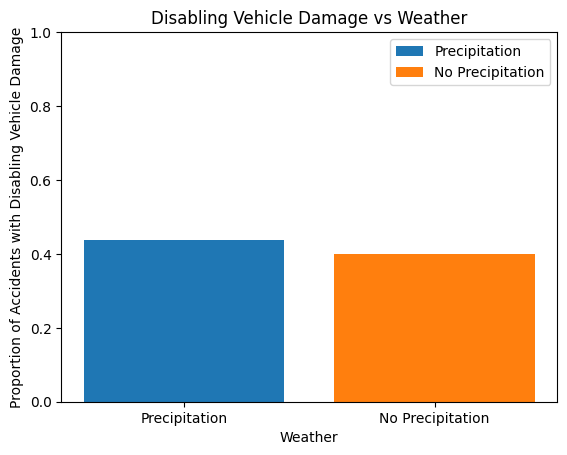

In [ ]:
disabling_given_precipitation = (precipitation_accidents_df[precipitation_accidents_df['Vehicle Damage Extent'] == 'Disabling'].shape[0]) / precipitation_accidents_df.shape[0]
disabling_given_no_recipitation = (no_precipitation_accidents_df[no_precipitation_accidents_df['Vehicle Damage Extent'] == 'Disabling'].shape[0]) / no_precipitation_accidents_df.shape[0]

print("Likelihood of disabling damage with precipitation:", disabling_given_precipitation)
print("Likelihood of disabling damage with no precipitation:", disabling_given_no_recipitation)

plt.bar('Precipitation', disabling_given_precipitation, label='Precipitation')
plt.bar('No Precipitation', disabling_given_no_recipitation, label='No Precipitation')

plt.xlabel('Weather')
plt.ylabel('Proportion of Accidents with Disabling Vehicle Damage')
plt.title('Disabling Vehicle Damage vs Weather')
plt.ylim(0.00, 1.00)
plt.legend()

We can now perform a two-sample z-test of proportions to see whether there is a difference in the proportion of vehicle accidents with disabling damage between the two groups. The sample size of each group is large enough. We will use a significance level of 0.05.

In [ ]:
z_stat, p_value = proportions_ztest(
      count=[disabling_given_precipitation * num_precipitation_accidents,
             disabling_given_no_recipitation * num_no_precipitation_accidents],
      nobs=[num_precipitation_accidents, num_no_precipitation_accidents],
      alternative="larger")

print("P-value:", p_value)

P-value: 6.169317852562975e-24


Since the p-value of 6.169317852562975e-24 is less than the significance value of 0.05, we will reject the null hypothesis. This supports the idea that the proportion of accidents that involved disabling vehicle damage is greater for accidents with precipitation than for accidents with no precipitation.

### Hypothesis 2: Traffic Controls and Injury Accidents per Year 🤕

Now we will be examining whether certain traffic controls have a higher average number of injury accidents per year than others.

**Null Hypothesis:** The type of traffic control does not affect the number of injury accidents per year.

**Alternative Hypothesis:** Stricter traffic controls have a lower number of injury accidents per year.

We will need to extract the crash year and create a new column for injury accidents with either a 0 (indicating it's not an injury crash) or a 1 (indicating it is an injury crash) so that we can find the sum of injury accidents for each year. Then we will groups these sums by the type of traffic control and create box plots for each type.

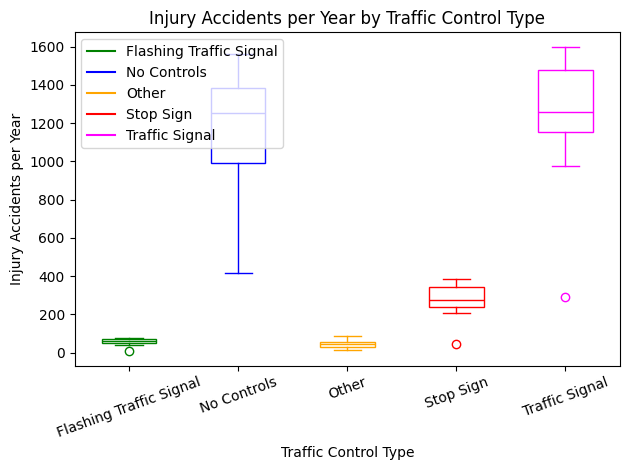

In [ ]:
from matplotlib.lines import Line2D

# Preparing the data and creating finding the sum of injury accidents per year
df['Accident Year'] = df['Crash Date/Time'].dt.year
df['Injury Accidents'] = (df['Injury Severity'] != 'No Apparent Injury').astype(int)
Injury_Accidents_Per_Year = df.groupby(['Traffic Control', 'Accident Year'])['Injury Accidents'].sum().reset_index()
Injury_Accidents_Per_Year

plot_data = []
for traffic_control in Injury_Accidents_Per_Year['Traffic Control'].unique():
  plot_data.append(Injury_Accidents_Per_Year[Injury_Accidents_Per_Year['Traffic Control'] == traffic_control]['Injury Accidents'])

# Create a graph showing the distributions of each control type
colors = ['green', 'blue', 'orange', 'red', 'magenta']
plots = plt.boxplot(plot_data, patch_artist=True, boxprops={'facecolor' : 'white'})
for i in range(len(plots['boxes'])) :
  plots['boxes'][i].set(edgecolor=colors[i])
  plots['medians'][i].set(color=colors[i])
  plots['whiskers'][i * 2].set(color=colors[i])
  plots['whiskers'][i * 2 + 1].set(color=colors[i])
  plots['caps'][i * 2].set(color=colors[i])
  plots['caps'][i * 2 + 1].set(color=colors[i])
  plots['fliers'][i].set(markeredgecolor=colors[i])
plt.xlabel('Traffic Control Type')
plt.ylabel('Injury Accidents per Year')
plt.title(f'Injury Accidents per Year by Traffic Control Type')
plt.xticks([1, 2, 3, 4, 5], ['Flashing Traffic Signal', 'No Controls', 'Other', 'Stop Sign', 'Traffic Signal'], rotation=20, ha='center')
plt.tight_layout()

# Create and plot a custom legend
legend_elements = [Line2D([0], [0], color=colors[0], ls='-', label='Flashing Traffic Signal'),
                   Line2D([0], [0], color=colors[1], ls='-', label='No Controls'),
                   Line2D([0], [0], color=colors[2], ls='-', label='Other'),
                   Line2D([0], [0], color=colors[3], ls='-', label='Stop Sign'),
                   Line2D([0], [0], color=colors[4], ls='-', label='Traffic Signal')]
plt.legend(handles=legend_elements, loc='upper left')

plt.show()

Now to determine if there are differences between the average number of injury accidents per year for each traffic control type we will preform an anova test.

In [ ]:
anova_results = f_oneway(*plot_data)
print("P-value:", anova_results.pvalue)

P-value: 8.686338286194073e-21


Our ANOVA test resulted in the p-value of 8.686338286194073e-21. This value is less than our signifcance value of 0.05, so we reject the null hypothesis. We now have some support that the type of traffic control can impact the number of injury accidents per year.

To determine which traffic controls are statistically different from each other, we must now run a post-hoc test. We chose to do a Tukey HSD test. You can read more about it here, https://real-statistics.com/one-way-analysis-of-variance-anova/unplanned-comparisons/tukey-hsd/.

In [ ]:
tukey_results = tukey_hsd(*plot_data)
print(tukey_results.pvalue)
print(tukey_results)

[[1.00000000e+00 0.00000000e+00 9.99955465e-01 1.64607303e-01
  0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 2.02282635e-11
  9.38643235e-01]
 [9.99955465e-01 0.00000000e+00 1.00000000e+00 1.29661552e-01
  0.00000000e+00]
 [1.64607303e-01 2.02282635e-11 1.29661552e-01 1.00000000e+00
  1.46604950e-12]
 [0.00000000e+00 9.38643235e-01 0.00000000e+00 1.46604950e-12
  1.00000000e+00]]
Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)  -1099.273     0.000 -1368.671  -829.875
 (0 - 2)     11.182     1.000  -258.216   280.580
 (0 - 3)   -218.182     0.165  -487.580    51.216
 (0 - 4)  -1172.364     0.000 -1441.761  -902.966
 (1 - 0)   1099.273     0.000   829.875  1368.671
 (1 - 2)   1110.455     0.000   841.057  1379.852
 (1 - 3)    881.091     0.000   611.693  1150.489
 (1 - 4)    -73.091     0.939  -342.489   196.307
 (2 - 0)    -11.182     1.000  -280.580   258.216
 (2 - 1)  -1110.455     0.000 -

From the results of the Tukey HSD test, we can see that most of the p-values are less than our significance level of 0.05. This means that the injury rates among almost all of the groups are statistically different from each other, with the exception of Flashing Traffic Signals and Stop Sign, Flashing Traffic Signals and Other, No Controls and Traffic Signal, and Other and Stop Sign.

### Hypothesis 3: Light Levels and Injury Severity 🔦

Finally, we wish to find out whether a difference in light levels affects injury severity.

**Null Hypothesis:** Light level during the accident and injury severity are independent.
In other words, light level has no effect on injury severity.



**Alternative Hypothesis:** Light level during the accident and injury severity are not independent.
That means that light level does affect injury severity.



We will be using a chi-squared test because both variables are categorical. First, let's create a contingency table.

In [ ]:
cont_table = pd.crosstab(df["Light"], df["Injury Severity"])
cont_table

Injury Severity,Fatal Injury,Minor Injury,No Apparent Injury,Serious Injury
Light,,,,
Dark,12,879,3647,59
Daylight,59,20022,87372,892
Low Light,59,7788,35116,427


The contingency table allows us to see the amount of entries for each category pair. Now, we can run the chi-squared test.

In [ ]:
chi2, p, dof, expected = chi2_contingency(cont_table)

print(f"Chi-squared Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {dof}")
print(f"P-value: {p}")

expected_df = pd.DataFrame(expected,
                           index=cont_table.index,
                           columns=cont_table.columns)
print("\nExpected Frequencies:")
print(expected_df.round(2))

Chi-squared Statistic: 68.23
Degrees of Freedom: 6
P-value: 9.411802098611102e-13

Expected Frequencies:
Injury Severity  Fatal Injury  Minor Injury  No Apparent Injury  \
Light                                                             
Dark                     3.82        843.61             3709.05   
Daylight                90.10      19882.75            87417.14   
Low Light               36.08       7962.64            35008.81   

Injury Severity  Serious Injury  
Light                            
Dark                      40.52  
Daylight                 955.02  
Low Light                382.46  


The p-value came back as p = 9.411802098611102e-13. This is a very small number, and because it is less than the alpha value of 0.05, we can reject the null hypothesis and conclude that the relationship between injury severity and light level is not independent. However, one thing to take into consideration is the disproportionately larger amount of daylight entries as compared to the other two light categories. This has most likely skewed the results and created statistical significance. To properly understand the impact of light on injury severity, let's make a heatmap of the standardized residuals to understand which category pairs are out of the ordinary.

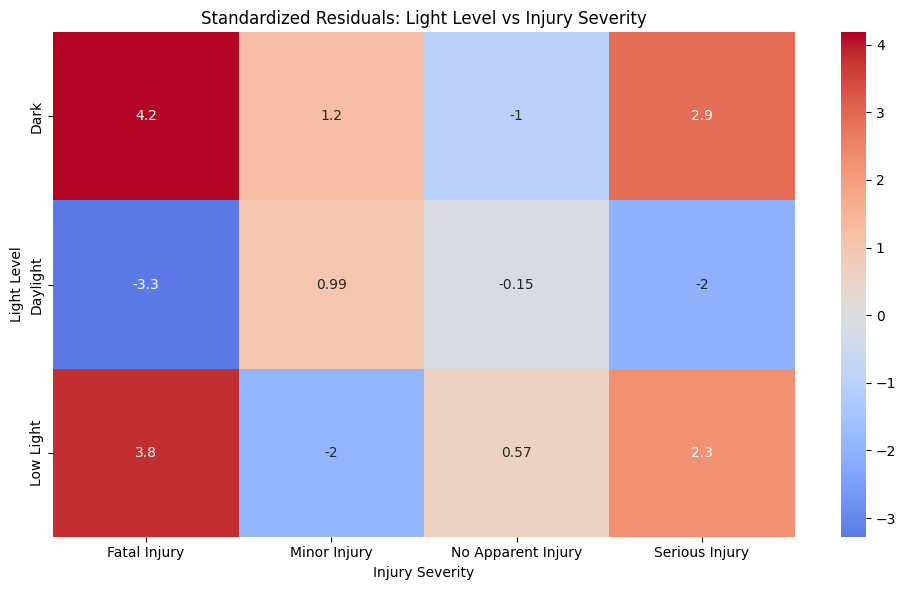

In [ ]:
residuals = (cont_table - expected) / np.sqrt(expected)

# Optional: Visualize residuals
plt.figure(figsize=(10, 6))
sns.heatmap(residuals, annot=True, cmap="coolwarm", center=0)
plt.title("Standardized Residuals: Light Level vs Injury Severity")
plt.ylabel("Light Level")
plt.xlabel("Injury Severity")
plt.tight_layout()
plt.show()

As long as the absolute value of the number in each box is greater than 2, we can say that the cell represents data that significantly deviates from what is expected. Some important categories to note are the number of fatal injuries in low and dark lighting, which both have the values of 3.6 and 4.3 respectively. Additionally, the number of serious and fatal accidents in daylight are also lower than what is expected. This insinuates that in a standardized environment, more fatal injuries happen in the dark than in the day.

In order to test the strength of the association shown in the chi-squared test, we can use Cramer's V test (gives values from 0 - 1).

In [ ]:
n = cont_table.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(cont_table.shape)-1)))
print(f"Cramér's V: {cramers_v:.3f}")

Cramér's V: 0.015


The value of the association is 0.015, which is very low. This means that the association between light level and injury severity is not strong. However, this information must be understood in the correct context, as the overwhelming majority of the data entries were in the daylight. In conclusion, we can reject the null hypothesis. However, we must keep this over representation of daylight entries in mind, and look at the heatmap to understand the whole situation in the right context.

<a name="Machine-Learning-Analysis"></a>
# 5. Machine Learning Analysis 🤖

To understand more about the potential patterns behind the types of car accidents that occur, we will perform a cluster analysis on the traffic accident data points to investigate their various risk factors.

<a name="Feature-Engineering"></a>
## i. Feature Engineering

We must first perform feature engineering on the existing categorical features to transform them into numerical features.

In [ ]:
print(df.dtypes)

Crash Date/Time           datetime64[ns]
Speed Limit                        int64
Weather                           object
Surface Condition                 object
Light                             object
Injury Severity                   object
Traffic Control                   object
Driver Distracted By              object
Vehicle Damage Extent             object
Vehicle Year                       int64
Driver Substance Abuse            object
Route Type                        object
Accident Year                      int32
Injury Accidents                   int64
dtype: object


To make the feature encoding easier, let's drop any data points where any of the categorical variables have the value 'Other'. Let's also drop the data points where the 'Vehicle Damage Extent' is 'vehicle not at scene' and some leftover NaN values for 'Light'.

In [ ]:
old_dataset_size = df.shape[0]

df = df[(df['Weather'] != 'Other') &
        (df['Driver Distracted By'] != 'Other') &
        (df['Driver Substance Abuse'] != 'Other') &
        (df['Route Type'] != 'Other') &
        (df['Vehicle Damage Extent'] != 'Other') &
        (df['Surface Condition'] != 'Other') &
        (df['Traffic Control'] != 'Other')]

df = df[df['Vehicle Damage Extent'] != 'Vehicle Not At Scene']

df = df.dropna(subset=['Light'])

print("New Dataset Size:", df.shape[0] / old_dataset_size)

New Dataset Size: 0.935845200924022


We will perform ordinal encoding on the 'Vehicle Damage Extent', 'Surface Condition', 'Injury Severity', 'Traffic Control', and 'Light' columns. The categories for each feature will be ordered from least to most intense (e.g. least to most vehicle damage or least to most light).

In [ ]:
# Copy the original dataframe for later.
unencoded_df = df.copy()

vehicle_damage_extent_order = [['No Damage', 'Superficial', 'Functional', 'Disabling', 'Destroyed']]
vehicle_damage_enc = OrdinalEncoder(categories=vehicle_damage_extent_order)
df['Vehicle Damage Extent'] = vehicle_damage_enc.fit_transform(df[['Vehicle Damage Extent']])

surface_condition_order = [['Dry', 'Wet', 'Snow', 'Ice']]
surface_condition_enc = OrdinalEncoder(categories=surface_condition_order)
df['Surface Condition'] = surface_condition_enc.fit_transform(df[['Surface Condition']])

injury_severity_order = [['No Apparent Injury', 'Minor Injury', 'Serious Injury', 'Fatal Injury']]
injury_severity_enc = OrdinalEncoder(categories=injury_severity_order)
df['Injury Severity'] = injury_severity_enc.fit_transform(df[['Injury Severity']])

traffic_control_order = [['No Controls', 'Stop Sign', 'Flashing Traffic Signal', 'Traffic Signal', 'Other']]
traffic_control_enc = OrdinalEncoder(categories=traffic_control_order)
df['Traffic Control'] = traffic_control_enc.fit_transform(df[['Traffic Control']])

light_order = [['Dark', 'Low Light', 'Daylight']]
light_enc = OrdinalEncoder(categories=light_order)
df['Light'] = light_enc.fit_transform(df[['Light']])



Let's take a look at the new dataframe.

In [ ]:
df.head()

,Crash Date/Time,Speed Limit,Weather,Surface Condition,Light,Injury Severity,Traffic Control,Driver Distracted By,Vehicle Damage Extent,Vehicle Year,Driver Substance Abuse,Route Type,Accident Year,Injury Accidents
0,2021-05-27 19:40:00,0,Clear,0.0,2.0,0.0,0.0,Not Distracted,1.0,2017,None,Government-Owned Public Roads,2021,0
1,2023-08-11 18:00:00,15,Clear,0.0,2.0,0.0,0.0,Not Distracted,0.0,2018,None,Government-Owned Public Roads,2023,0
2,2023-12-06 18:42:00,35,Clear,0.0,1.0,0.0,1.0,Not Distracted,3.0,2017,None,Government-Owned Public Roads,2023,0
3,2023-08-28 11:09:00,30,Cloudy,0.0,2.0,0.0,0.0,Not Distracted,2.0,2010,None,Government-Owned Public Roads,2023,0
4,2023-07-27 12:30:00,30,Clear,0.0,2.0,0.0,0.0,Not Distracted,2.0,2022,None,Government-Owned Public Roads,2023,0


Now, let's perform one-hot encoding on the remaining categorical features.

In [ ]:
weather_enc = OneHotEncoder()
df['Weather'] = weather_enc.fit_transform(df[['Weather']]).toarray()
driver_distracted_enc = OneHotEncoder()
df['Driver Distracted By'] = driver_distracted_enc.fit_transform(df[['Driver Distracted By']]).toarray()
substance_abuse_enc = OneHotEncoder()
df['Driver Substance Abuse'] = substance_abuse_enc.fit_transform(df[['Driver Substance Abuse']]).toarray()
route_type_enc = OneHotEncoder()
df['Route Type'] = route_type_enc.fit_transform(df[['Route Type']]).toarray()

Let's take a look at the new dataframe.

In [ ]:
df.head()

,Crash Date/Time,Speed Limit,Weather,Surface Condition,Light,Injury Severity,Traffic Control,Driver Distracted By,Vehicle Damage Extent,Vehicle Year,Driver Substance Abuse,Route Type,Accident Year,Injury Accidents
0,2021-05-27 19:40:00,0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,2017,0.0,1.0,2021,0
1,2023-08-11 18:00:00,15,1.0,0.0,2.0,0.0,0.0,0.0,0.0,2018,0.0,1.0,2023,0
2,2023-12-06 18:42:00,35,1.0,0.0,1.0,0.0,1.0,0.0,3.0,2017,0.0,1.0,2023,0
3,2023-08-28 11:09:00,30,0.0,0.0,2.0,0.0,0.0,0.0,2.0,2010,0.0,1.0,2023,0
4,2023-07-27 12:30:00,30,1.0,0.0,2.0,0.0,0.0,0.0,2.0,2022,0.0,1.0,2023,0


Finally, we wil drop the 'Injury Accidents' column, since it is redundant with the 'Injury Severity' column, as well as the 'Crash Date/Time' column, since the 'Accident_Year' column provides the same information.

In [ ]:
df = df.drop(columns=['Injury Accidents', 'Crash Date/Time'])

<a name="Cluster-Analysis"></a>
## ii. Cluster Analysis 📈

Now, we can perform the cluster analysis using k-means clustering. More info about k-means clustering can be found at https://www.geeksforgeeks.org/k-means-clustering-introduction/.

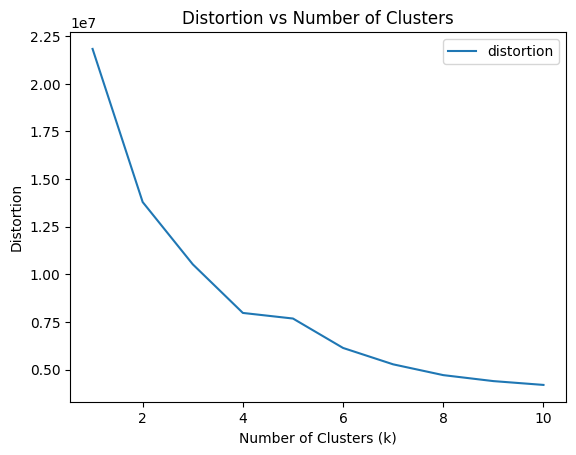

In [ ]:
distortions = []

for k in range(1, 11):
  kmeans = KMeans(n_clusters=k, random_state=random_seed)
  kmeans.fit(df)
  distortions.append(kmeans.inertia_)

plt.plot(range(1, 11), distortions, label='distortion')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Distortion vs Number of Clusters')
plt.legend()
plt.show()

Using the elbow method, we can see that the optimal number of clusters is 7, since the decrease in distortion levels off after that point.

In [ ]:
num_clusters = 7

kmeans = KMeans(n_clusters=num_clusters, random_state=random_seed)
kmeans.fit(df)

KMeans(n_clusters=7, random_state=42)

<a name="Visualization"></a>
# 6. Visualization 📊

Now, let's visualize the clusters and analyze them. We can try plotting a 3D scatterplot first using three of the features.

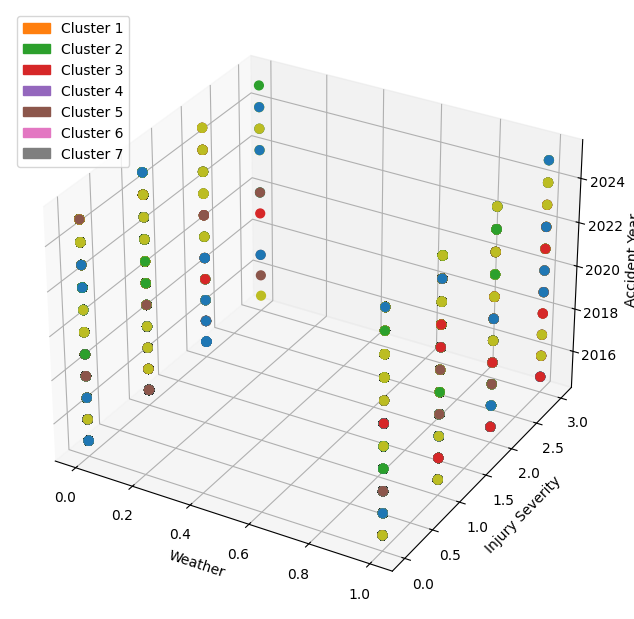

In [ ]:
x = 'Weather'
y = 'Injury Severity'
z = 'Accident Year'

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("tab10", 256).as_hex())

scatterplot = ax.scatter(df[x], df[y], df[z], s=40, c=kmeans.labels_, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)

mapping = [
    Patch(color=cmap(i+1), label=f"Cluster {i+1}")
    for i in range(num_clusters)
]

ax.legend(handles=mapping, loc='best')

plt.show()

As you can see, the data is too sparse to draw any meaningful conclusions from visually analyzing the 3D scatterplot.

Instead, let's try drawing the distributions of each variable and compare them between clusters.

In [ ]:
# Get the number of features.
num_features = len(df.columns)
# Get the feature names.
feature_names = df.columns

First, let's draw the plots for the entire dataset as a reference.

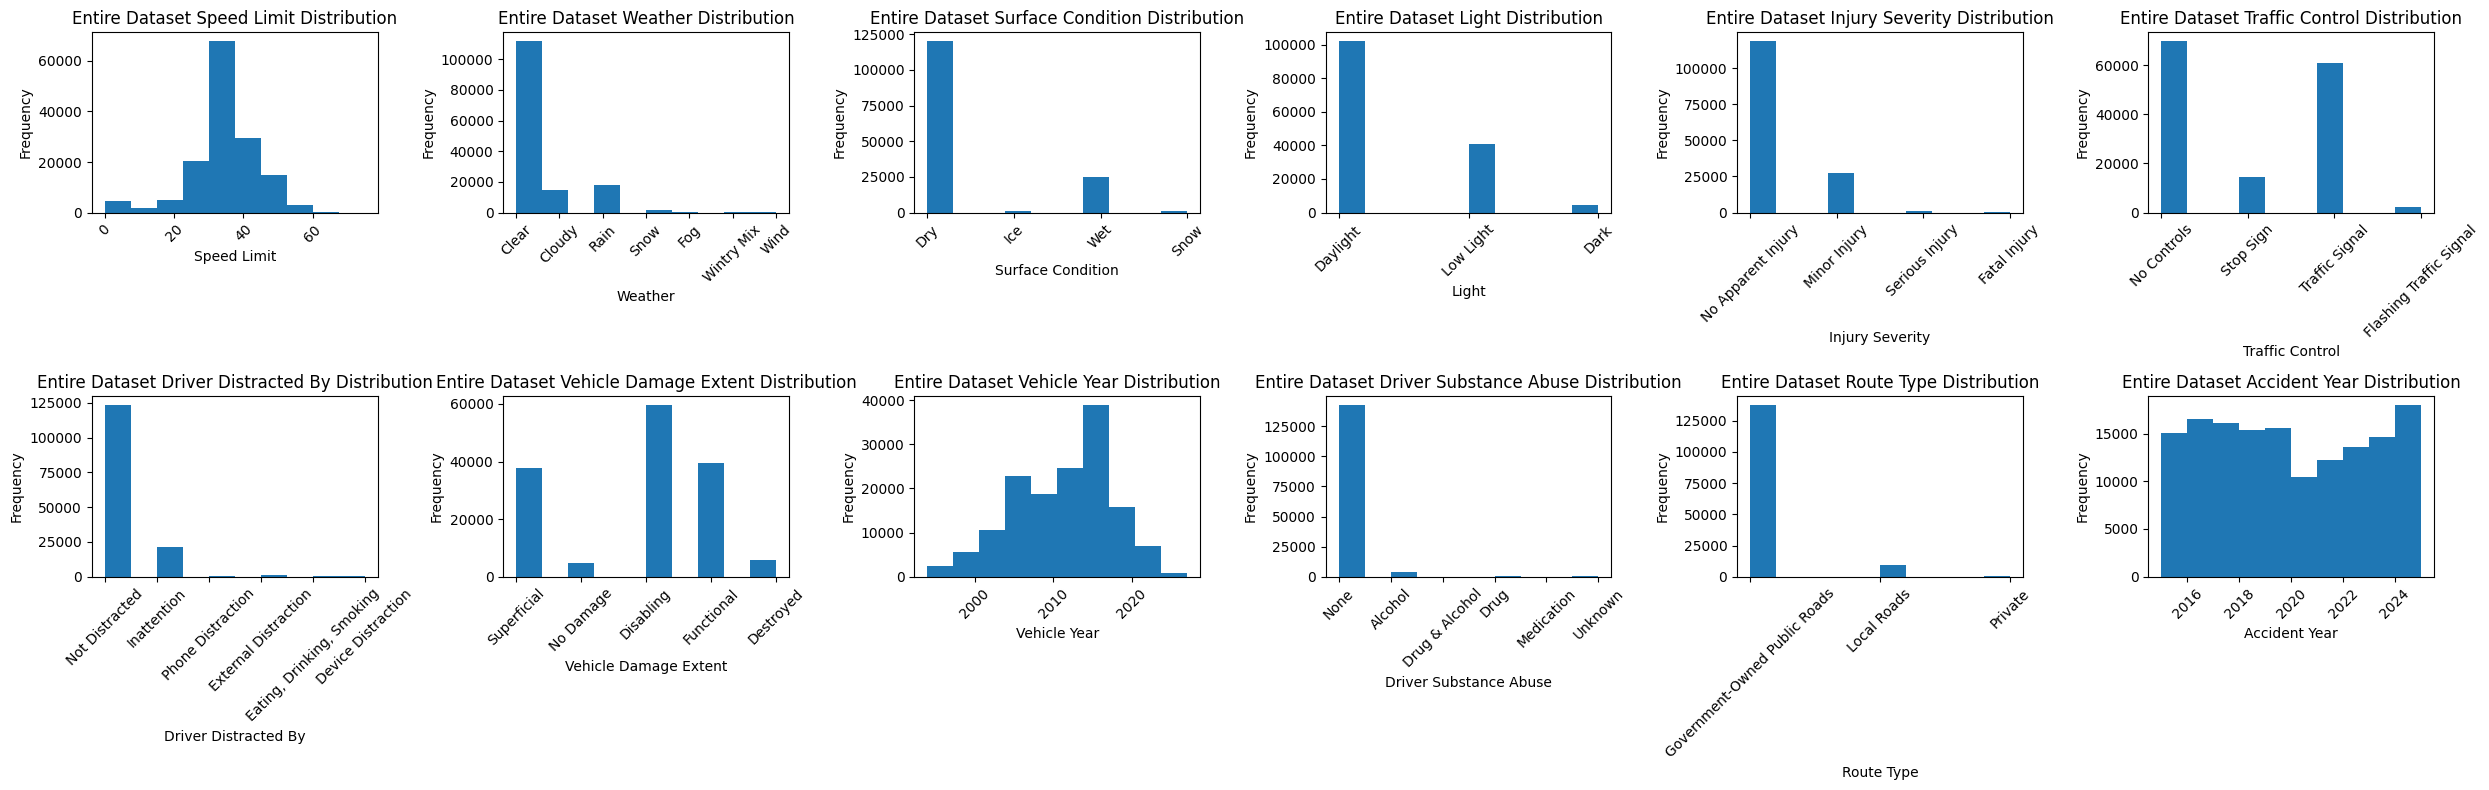

In [ ]:
# Plot a plot for each feature on one line.
fig, axs = plt.subplots(nrows=2, ncols=int(num_features / 2), figsize=(25, 8))

# Plot a plot for each feature for the entire dataset.
for feature_i in range(num_features):
  # Get the feature name.
  feature_name = feature_names[feature_i]

  # Draw the histogram.
  x = 0 if feature_i < 6 else 1
  y = feature_i % 6
  axs[x, y].hist(unencoded_df[feature_name])
  axs[x, y].set_title(f"Entire Dataset {feature_name} Distribution")
  axs[x, y].set_xlabel(feature_name)
  axs[x, y].set_ylabel("Frequency")
  axs[x, y].tick_params(axis='x', labelrotation=45)

# Show the plots.
plt.tight_layout()
plt.show()


Let's also analyze the overall distribution of clusters within the dataset.

Text(0.5, 1.0, 'Frequency of Clusters')

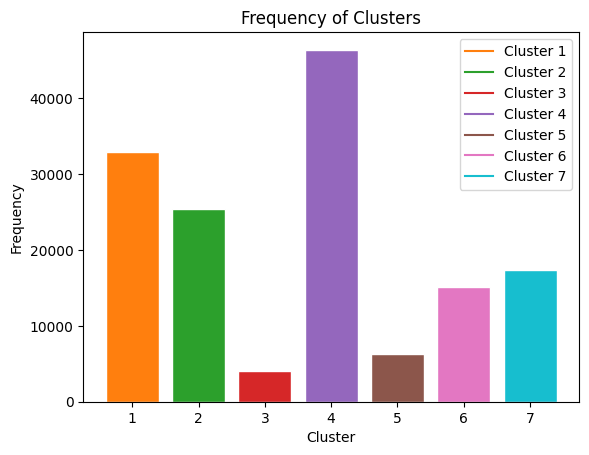

In [ ]:
from matplotlib.lines import Line2D

# Get the frequency counts for each cluster.
cluster_labels = [cluster_i + 1 for cluster_i in kmeans.labels_]
values, counts = np.unique(cluster_labels, return_counts=True)

# Set the colors for the barplot.
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan']

# Plot the frequency of each cluster.
fig, ax = plt.subplots()
bars = ax.bar(values, counts, color=colors, edgecolor='white', linewidth=1)

# Create and plot a custom legend.
legend_elements = [Line2D([0], [0], color=colors[i], ls='-', label=f'Cluster {i + 1}') for i in range(0, num_clusters)]
plt.legend(handles=legend_elements, loc='upper right')

# Add the labels.
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency of Clusters')

Now we can draw the plots for each cluster one by one to make it easier to analyze and understand the characteristics of each cluster.

In [ ]:
def plot_cluster_distributions(cluster_i, color):
  # Plot a plot for each feature on two lines.
  fig, axs = plt.subplots(nrows=2, ncols=int(num_features / 2), figsize=(25, 8))

  # Get the data points belonging to that cluster.
  cluster_df = unencoded_df[kmeans.labels_ == cluster_i]

  # Plot a plot for each feature for this cluster.
  for feature_i in range(num_features):
    # Get the feature name.
    feature_name = feature_names[feature_i]

    # Draw the histogram.
    x = 0 if feature_i < 6 else 1
    y = feature_i % 6
    axs[x, y].hist(cluster_df[feature_name], color=color)
    axs[x, y].set_title(f"Cluster {cluster_i + 1} {feature_name} Distribution")
    axs[x, y].set_xlabel(feature_name)
    axs[x, y].set_ylabel("Frequency")
    axs[x, y].tick_params(axis='x', labelrotation=45)

  # Show the plots.
  plt.tight_layout()
  plt.show()

Let's start by drawing the plots for cluster 1.

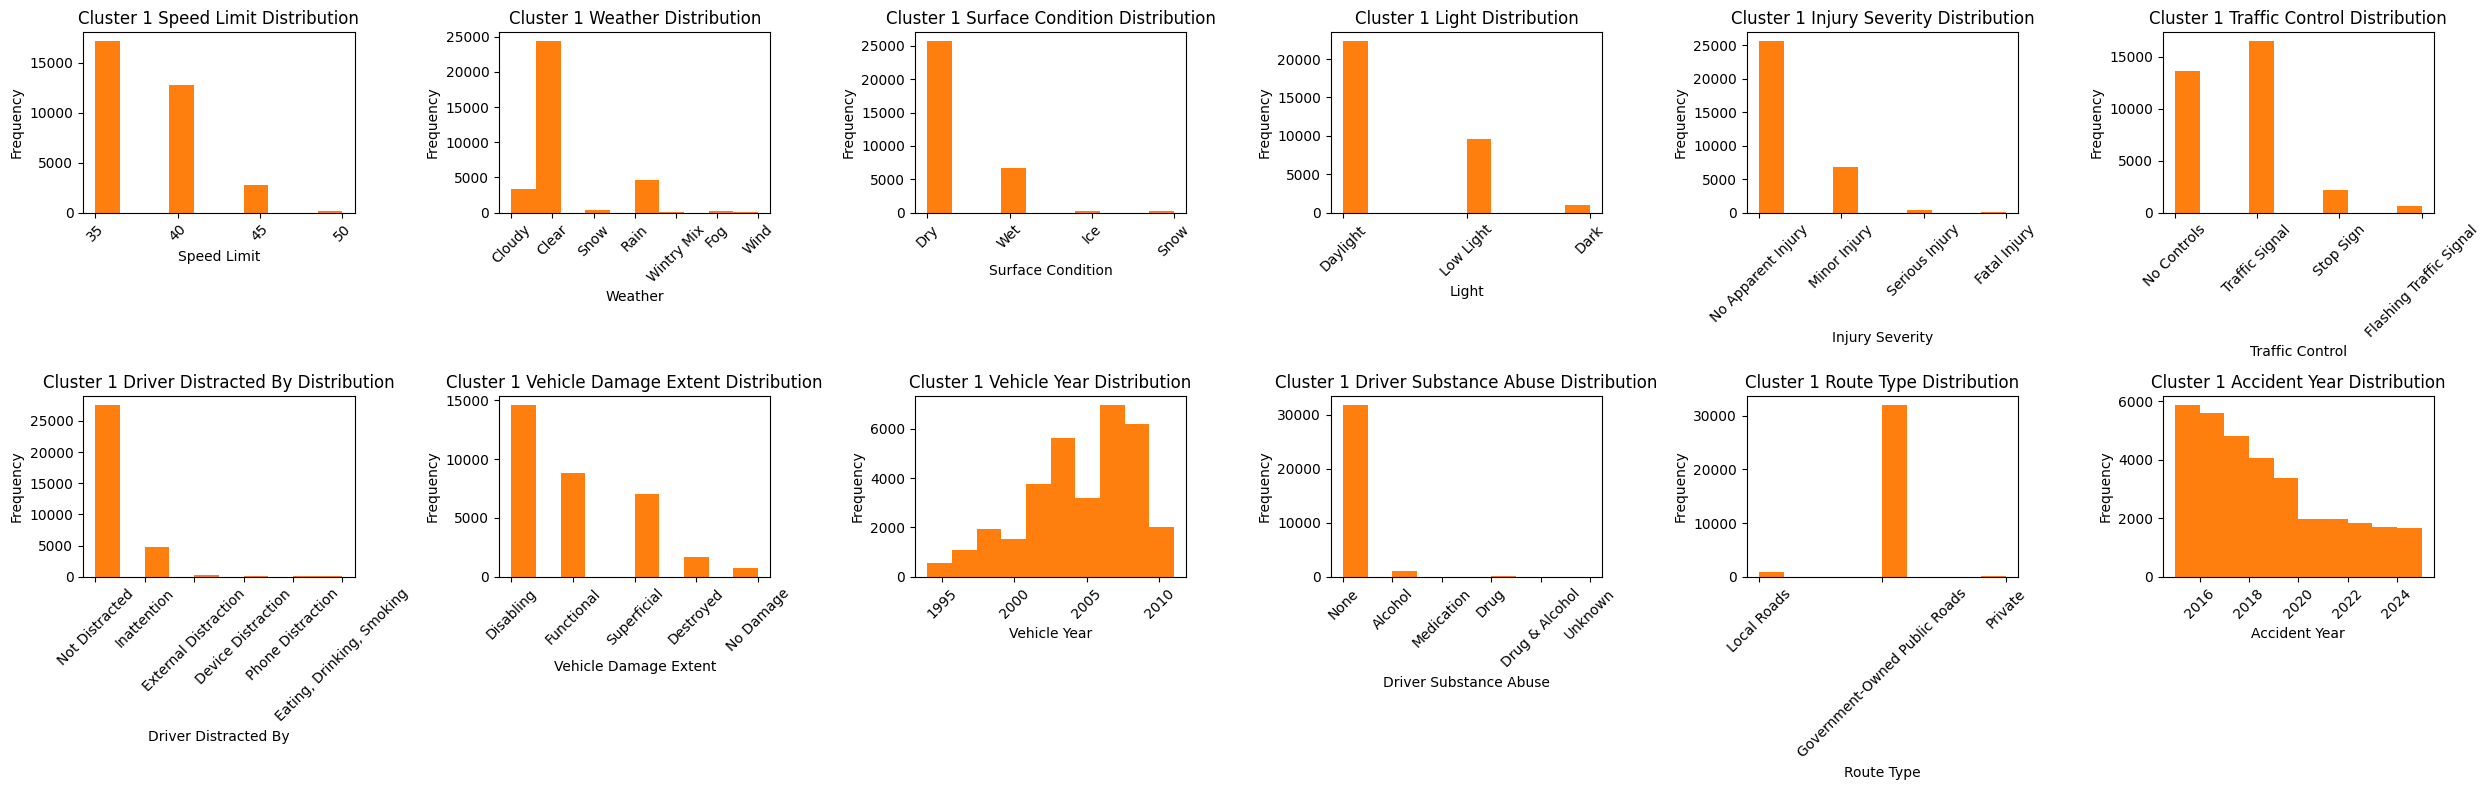

In [ ]:
# We will draw the plots for cluster 1 first.
plot_cluster_distributions(cluster_i=0, color='tab:orange')


Cluster 1 involves crashes occurring on moderate to high-speed roads (35-45mph primarily) under ideal weather and surface conditions. With occasional instances of cloudy, rainy, or wet states. Most of these happened during daylight, with a decent chunk still during low-light conditions. The majority of these incidents result in no injury or minor injury, nearly all taking place at traffic signals or no traffic controls. Almost all are sober, and most are not distracted, with the damage sustained ranging from disabling to more minor levels typically. This cluster focuses on older cars as well, where the frequency of these accidents have been decreasing.

Compared to the overall dataset, this cluster is focused on accidents from the moderate to higher-speed zones, with higher injury severity and higher vehicle damage extent. Otherwise the data follows most of the other trends of the entire dataset.

These patterns suggest crashes on high-volume main roads, including a mix of intersections and traffic controls.

Now, let's do cluster 2.

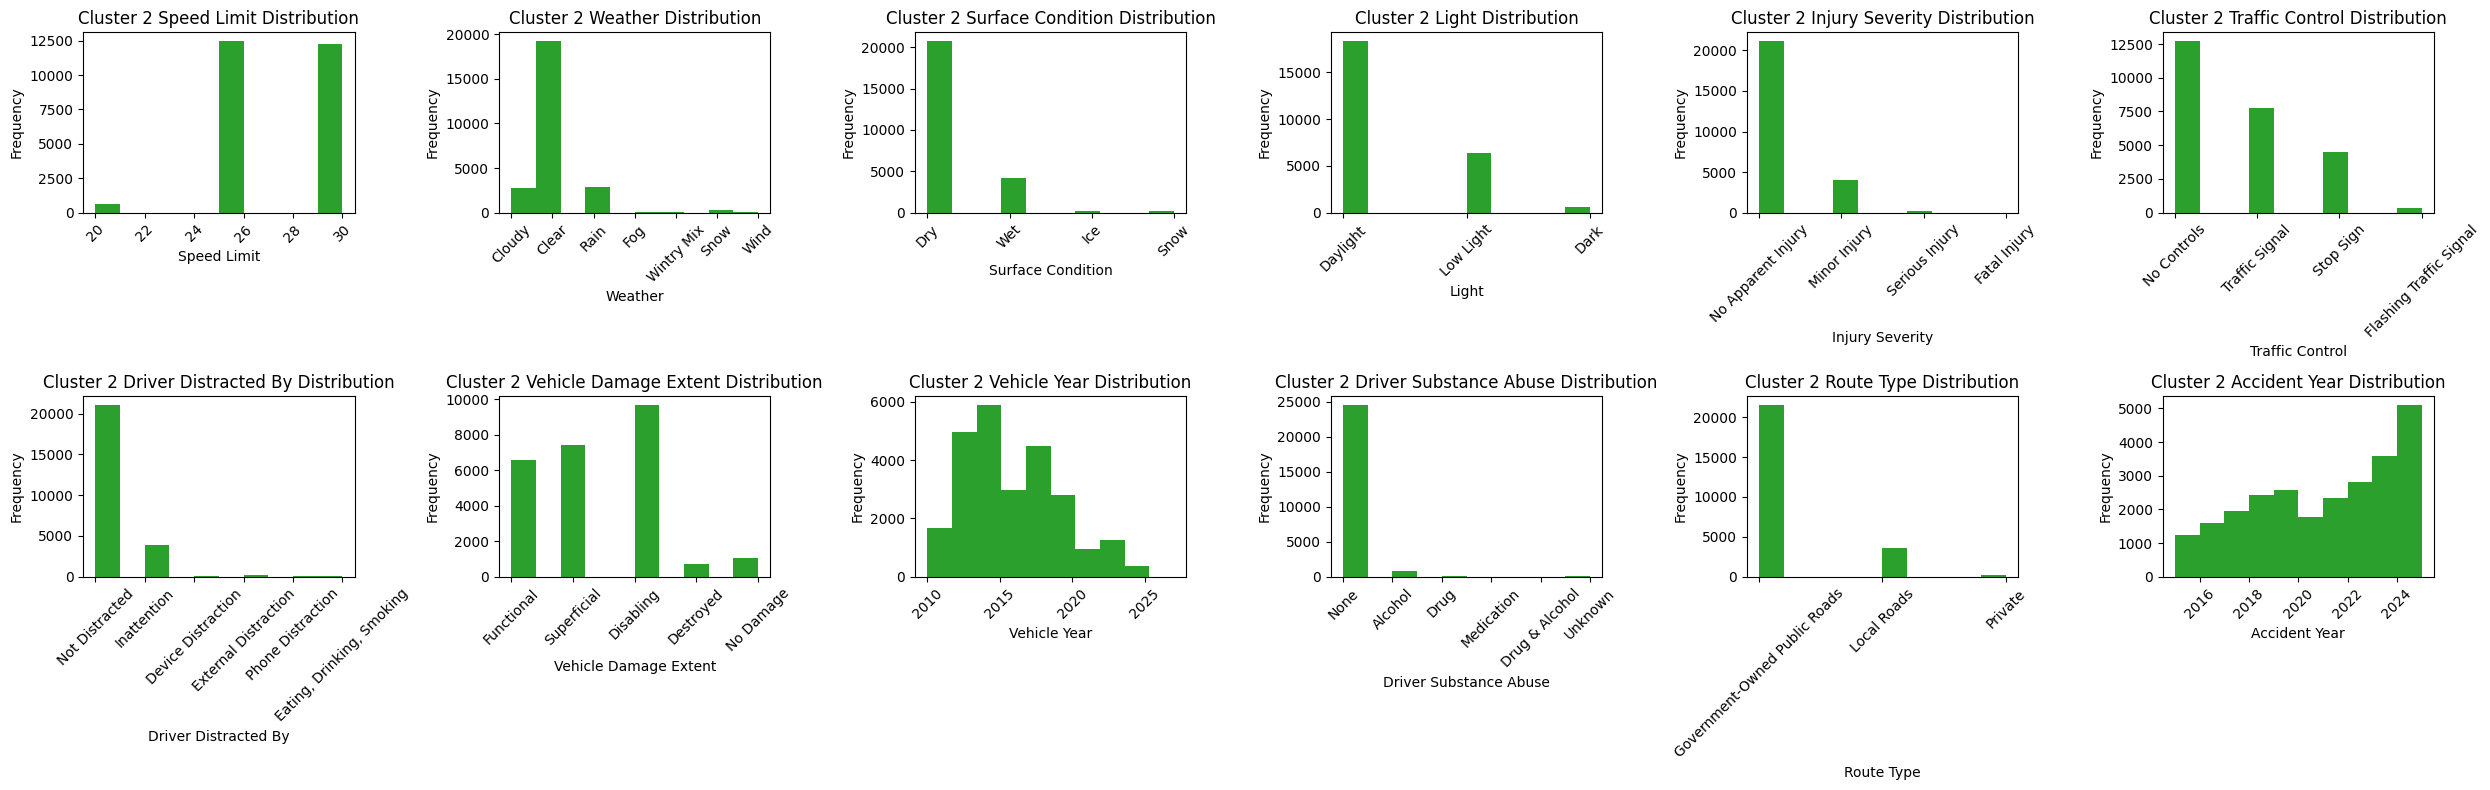

In [ ]:
# We will draw the plots for cluster 2.
plot_cluster_distributions(cluster_i=1, color='tab:green')


Cluster 2 involves crashes occuring at more moderate speeds (25-30mph, very few 20mph), primarily under ideal conditions being dry and clear. Occasional wet or low-light periods. With a split of traffic control between majority no controls, with quite a few for both at traffic signals and stop signs. Most crashes result in no injury or minor injury, with the vehicle damage being disabling, superficial or functional, being about moderate severity. Drivers are overwhelmingly not distracted and sober, with newer vehicle models. Where yet again, accident type has been declining over the years. Even quite a few of the routes being categorized as more local roads.

This cluster compared to the entire dataset focuses more on the slower to moderate speeds, and has more focus on newer cars compared to the entire dataset. The crash frequency here by year as well has been increasing compared to the entire dataset being consistent or slightly increasing.

This cluster suggests crashes more along suburban main streets or neighborhood connectors due to the consistent speeds and variety of crash controls.

Now, let's do cluster 3.

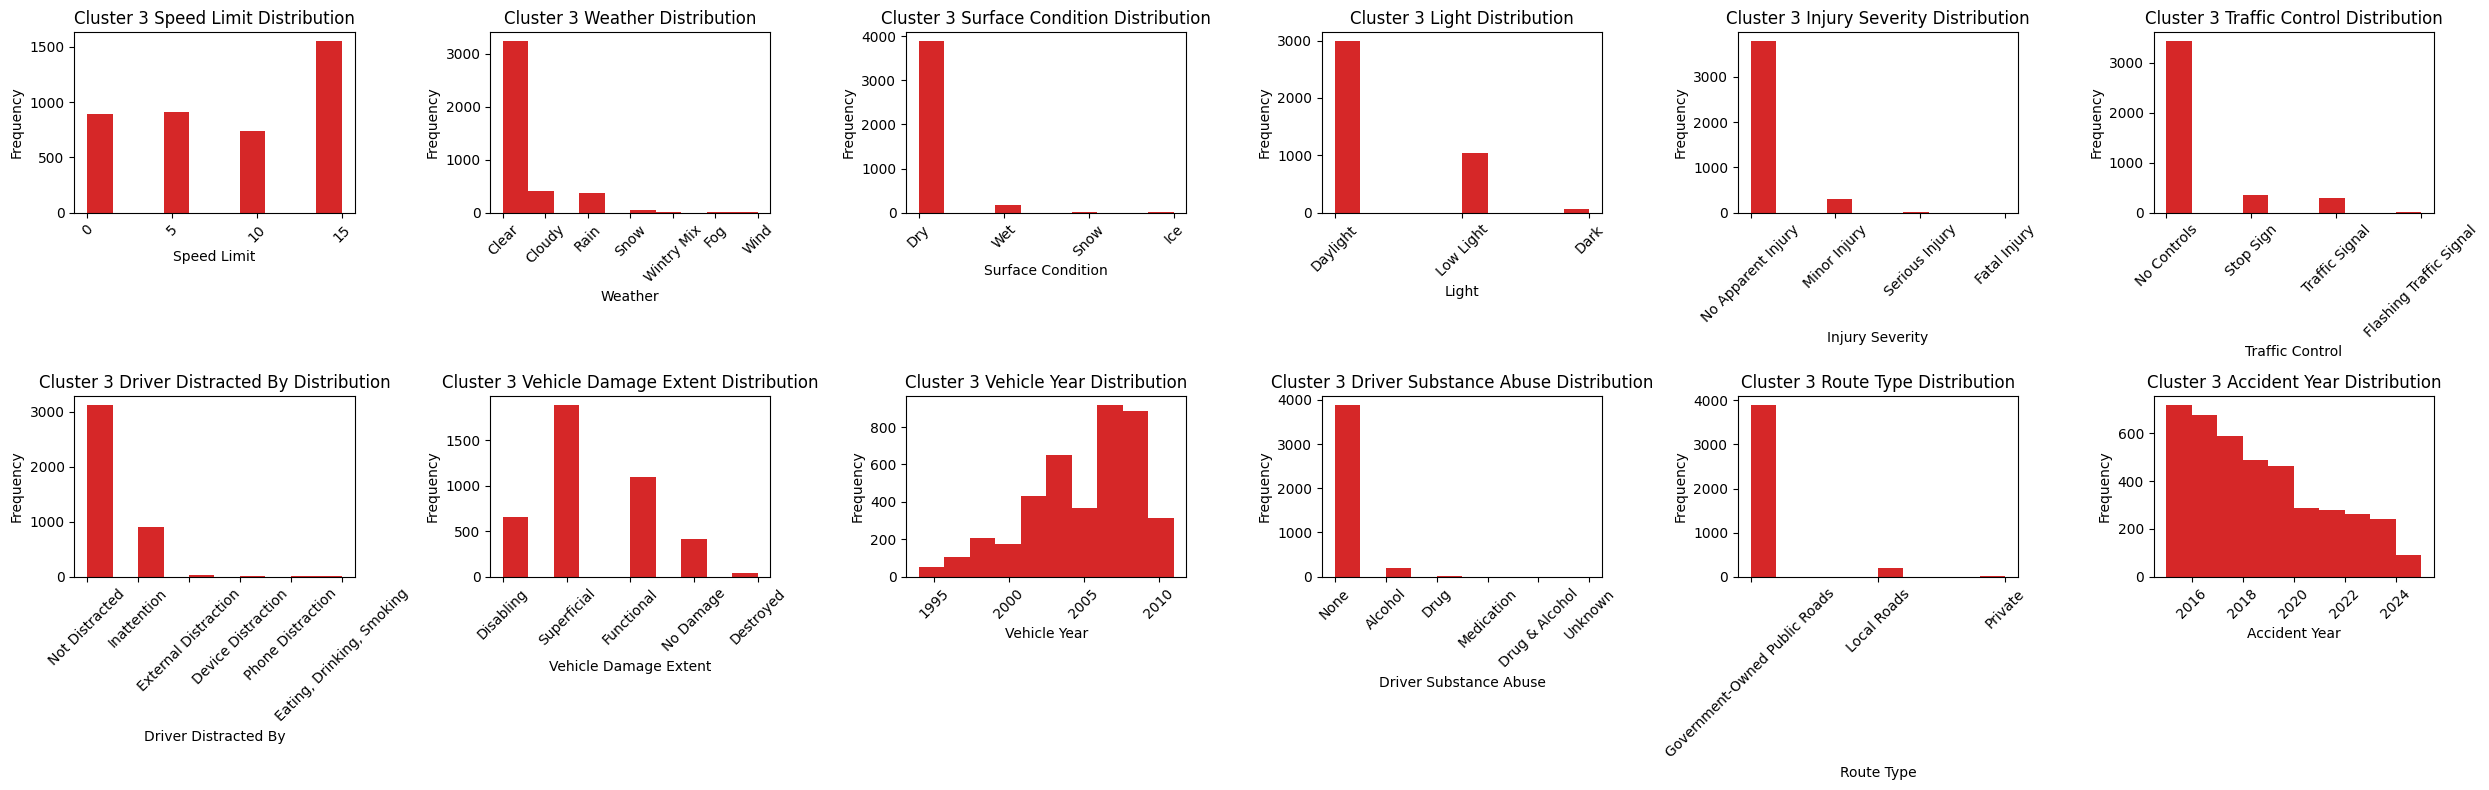

In [ ]:
# We will draw the plots for cluster 3.
plot_cluster_distributions(cluster_i=2, color='tab:red')

Cluster 3 involves crashes occuring at very low speeds (0-15mph), typically under ideal conditions, with the occasional incidents during low-light or cloudy/rainy days. Most of these crashes occur without traffic controls, and result in no injuries, most the vehicle damage is minor/superficial. Vehicle model is majority all older cars, with majority of drivers not distracted. These incidents have also been declining in frequency over the recent years.

This cluster in comparsion to the entire dataset focuses on the low end of speeds. As result, the vehicle damage extent is much more minor and cosmetic. Proportionally more of these happen under ideal conditions, with less accidents occurring in wet conditions, possibly reflecting greater levels of user error in low-speed environments. From being in these low-speed areas, the traffic controls are very different, where almost no traffic signals are present, and vehicle year is represented by older cars (2010 or older), as opposed to the full spectrum of the dataset. Lastly, the dataset crash frequency by year has decreased over the last few years, instead of staying steady or slightly increasing.

This cluster is of minor, low-impact collisions in parking environments or general low-speed settings, involving older cars. The frequency of this cluster overall is the smallest, showing why these types are comparatively very uncommon.

Now, let's do cluster 4.

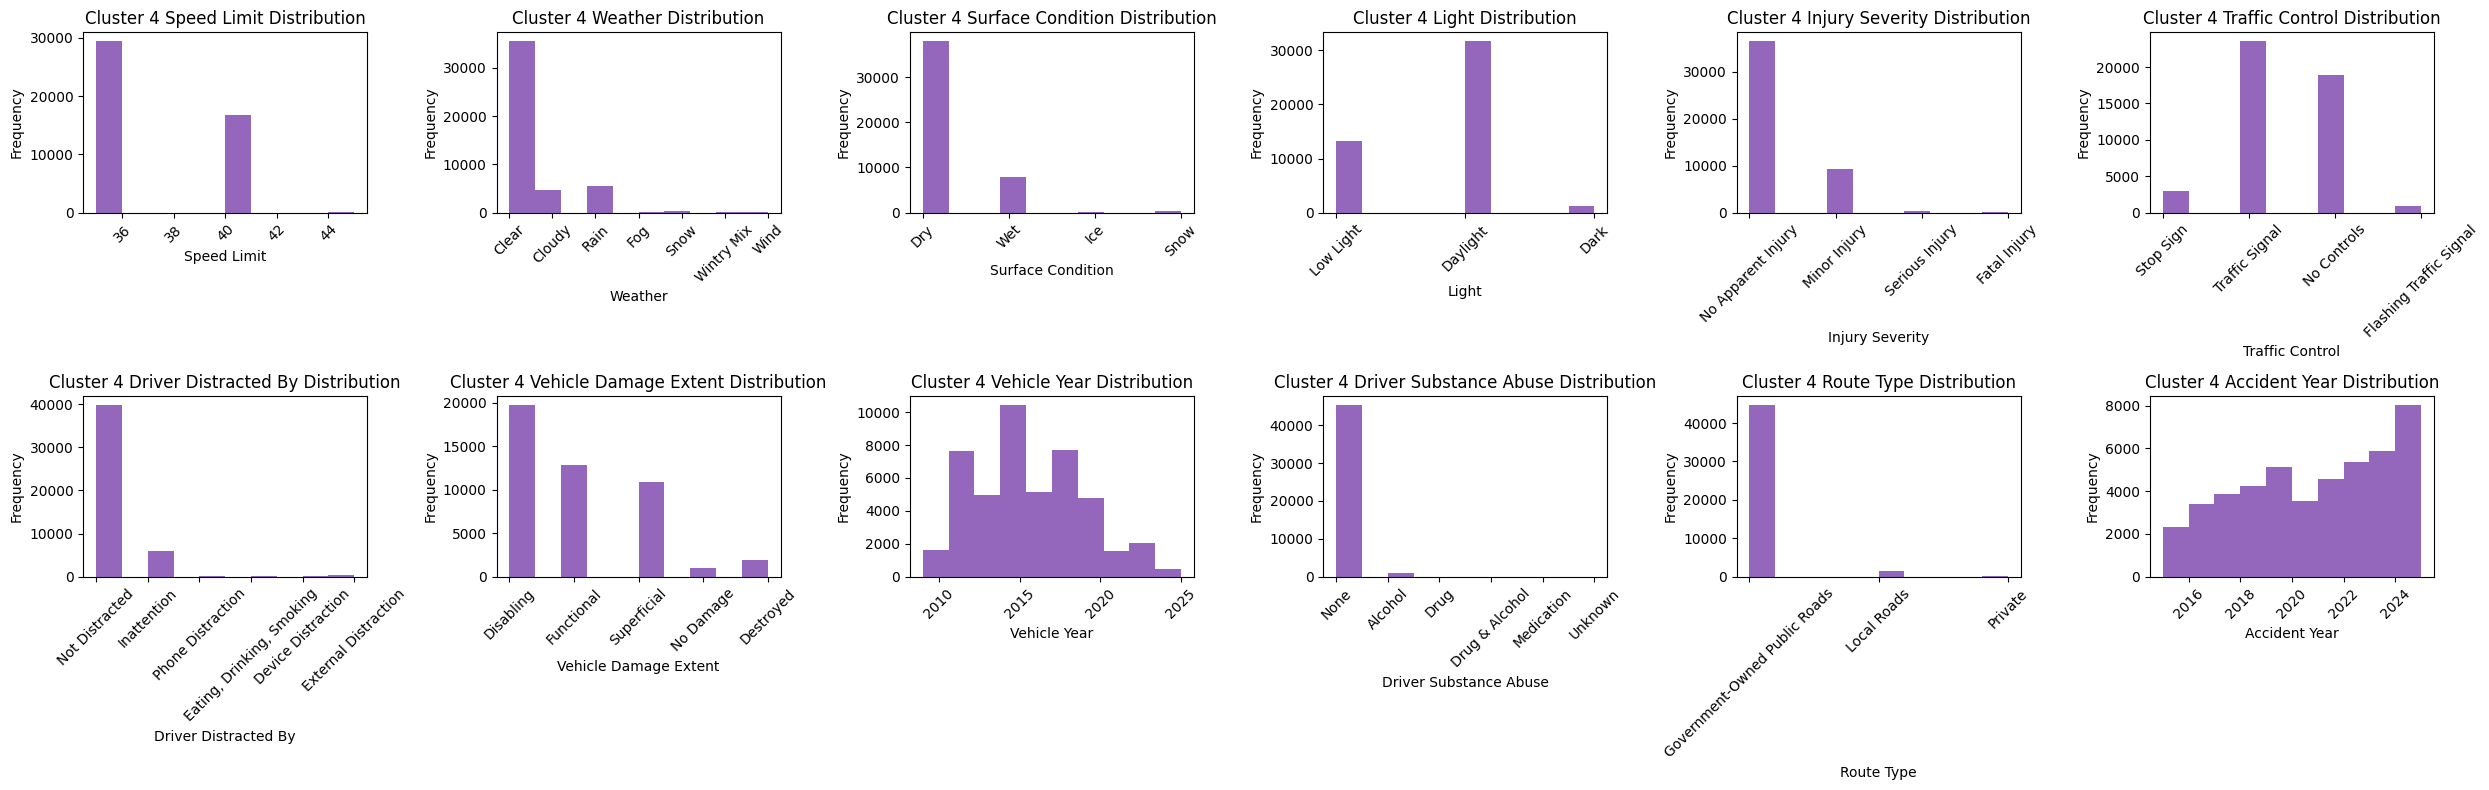

In [ ]:
# We will draw the plots for cluster 4.
plot_cluster_distributions(cluster_i=3, color='tab:purple')

Cluster 4 involves clusters at high moderate speeds (mostly 35-40mph), predominantly under ideal, dry and clear conditions. These occur largely during the daytime, although a noticeable amount at low-light settings. The crashes occur with traffic signals, no controls and a smaller portion at stop signs. Most of these crashes result in no or minor injuries, with vehicle damage often disabling, functional or superifical. Drivers are overwhemlingly sober and not distracted, with a lesser amount inattentive. The vehicle years tend to be of more recent models (2010 and newer). This cluster has had an increase in accidents over the last few years.

This cluster focuses on the bulk of the accidents, being at the higher moderate speeds. It also focuses more on newer cars and does not include the older cars that the entire dataset includes, while being more focused on traffic signals compared to no controls compared to the entire dataset. The rest of the cluster falls in line more with the dataset as a whole.

This pattern suggests more higher-volume urban or suburban main roads with moderate speeds and more intersections present. Cluster 4 is also the the cluster with by far the highest frequency overall.

Now, let's do cluster 5.

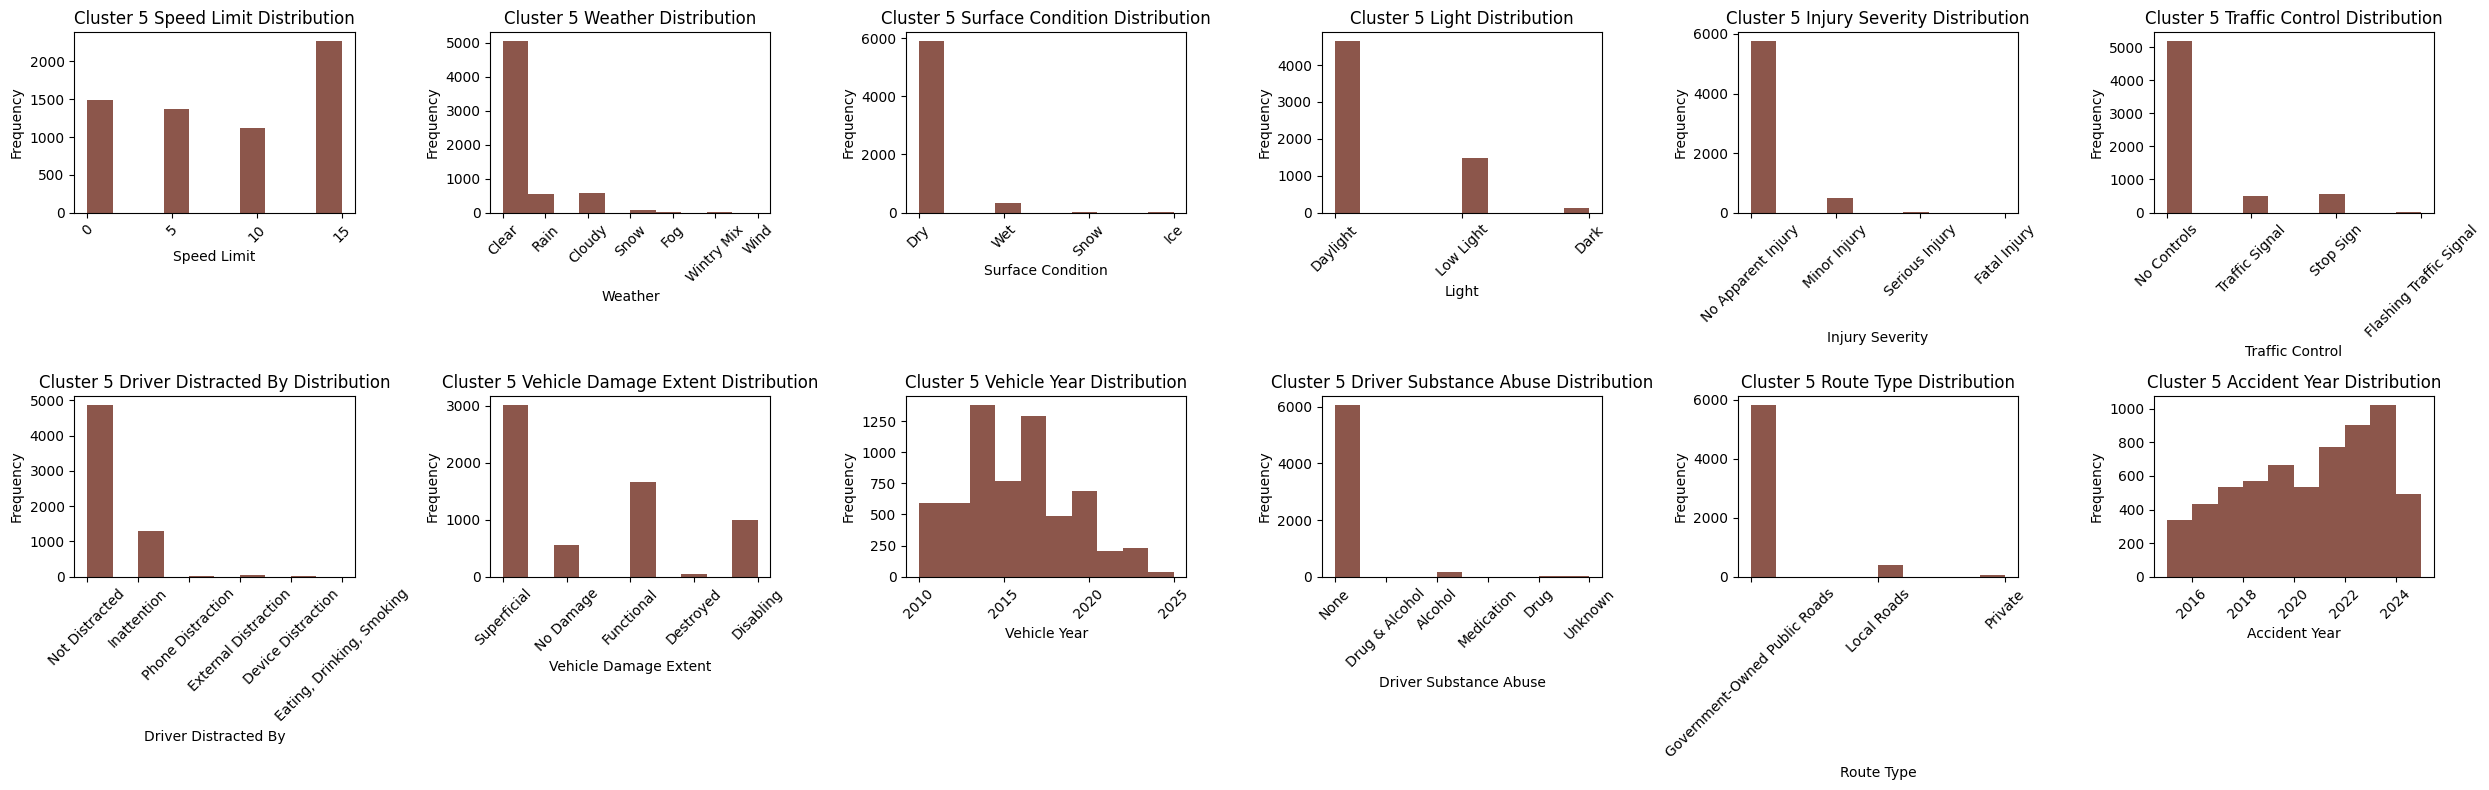

In [ ]:
# We will draw the plots for cluster 5.
plot_cluster_distributions(cluster_i=4, color='tab:brown')

Cluster 5 involves crashes occuring at very low speeds (0-15mph), typically under ideal conditions, with the occasional incidents during low-light or cloudy/rainy days. Most of these crashes occur without traffic controls, and result in no injuries, most the vehicle damage is minor/superficial. Vehicle model is majority newer cars, with majority of drivers not distracted. Where these incidents have also been increasing in frequency over the recent years (not including 2024)

This cluster, in comparsion to the entire dataset, focuses on the low end of speeds. As a result, the vehicle damage extent is much more minor and cosmetic. Proportionally more of these happen under ideal conditions, with a small proportion of wet conditions, reflecting greater levels of user error in low-speed environments. From being in these low-speed areas, the traffic controls are very different, where almost no traffic signals are present, vehicle year is represented by newer cars (2010 and newer), opposed to the full spectrum of the dataset including older cars.

This cluster is of minor, low-impact collisions in parking environments or general low-speed settings, involving newer cars. The frequency of this cluster overall is the smallest, showing why these types are comparatively very uncommon. Cluster 2 and Cluster 5 are very similar. However, the former involves older cars, with decreasing incidences over time, and the latter involves newer cars, with increasing incidences over time.

Now, let's do cluster 6.

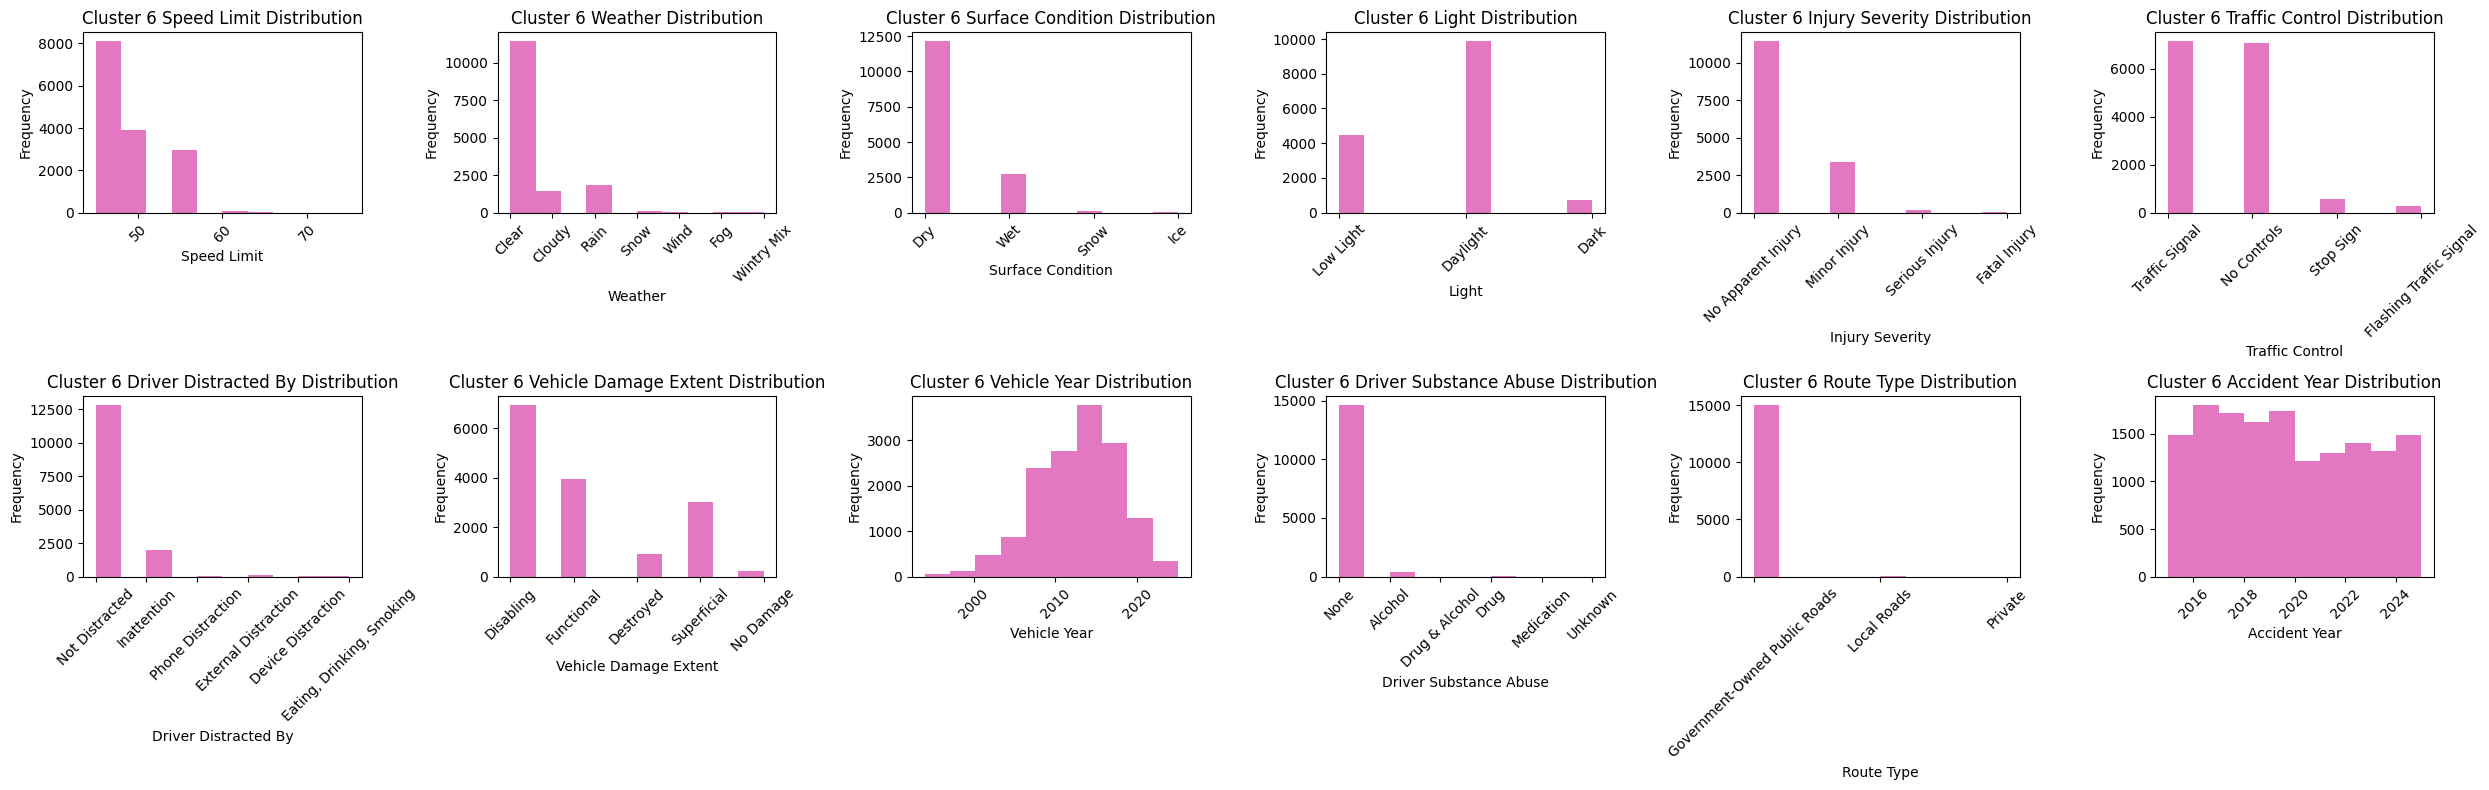

In [ ]:
# We will draw the plots for cluster 6.
plot_cluster_distributions(cluster_i=5, color='tab:pink')

Cluster 6 involves crashes occurring on high-speed roads (45mph and above), usually under ideal weather and surface conditions, with occasional instances of cloudy, rainy, or wet conditions. Most of these happened during daylight, with a decent chunk still during low-light conditions. The majority of these incidents result in minor or no injury, nearly all taking place at traffic signals or no traffic controls. Almost all are sober, and most are not distracted, with the damage sustained ranging from disabling to more minor levels typically. Vehicle year is very spread out, and the crash frequency has been plateauing in the last few years, after decreasing a number of years ago

Compared to the overall dataset, this is focused on accidents from the higher speed limit zones resulting in higher injury severity, but essentially follows most of the other trends of the entire dataset.

These patterns suggest crashes on multi-lane, high-volume roads or state highways, involving a mix of intersections or user error without traffic controls.

Now, let's do cluster 7.

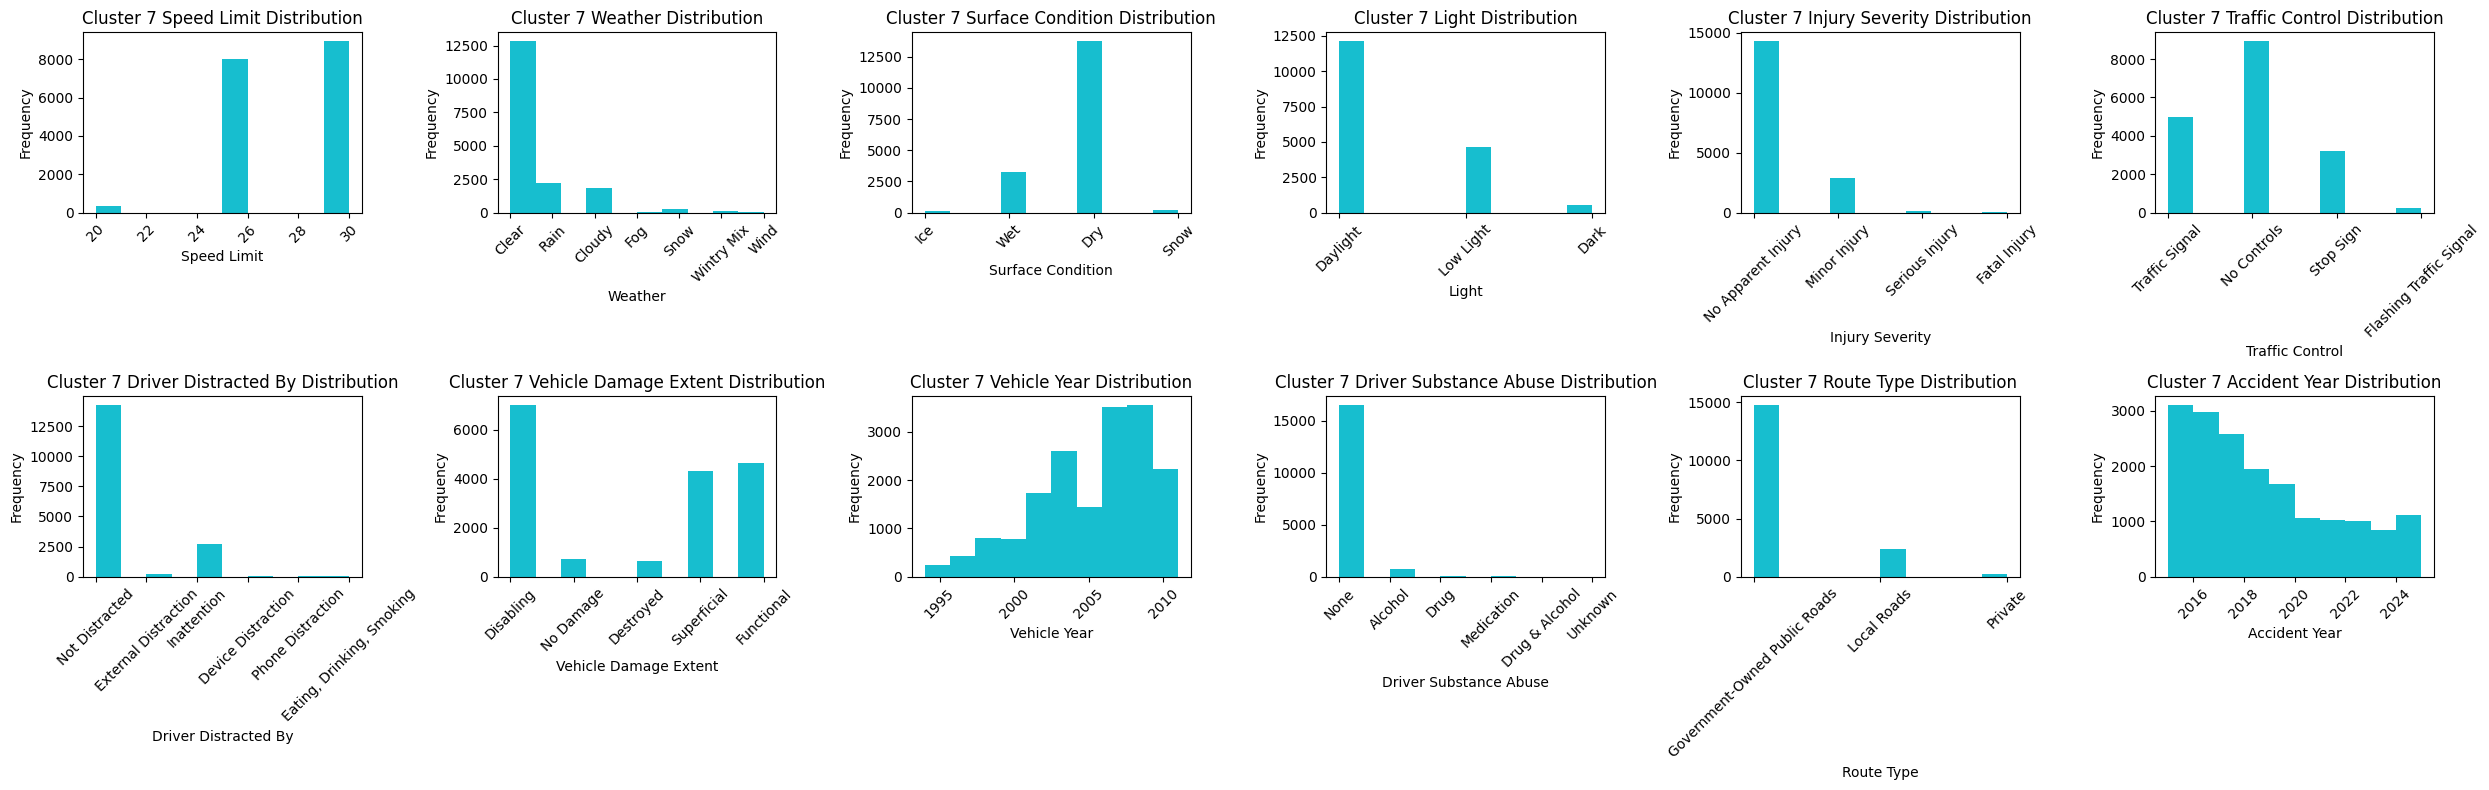

In [ ]:
# We will draw the plots for cluster 7.
plot_cluster_distributions(cluster_i=6, color='tab:cyan')

Cluster 7 involves crashes occuring at more moderate speeds (primarily 25-30mph), under ideal conditions (dry and clear), with occasional instances of cloudy, rainy, or wet conditions. With a split of traffic control between majority no controls, with quite a few for both at traffic signals and stop signs. Most crashes result in no injury or minor injury, with the vehicle damage being disabling, superficial or functional, being about middle severity. Drivers are heavily not distracted and sober, with older vehicle models. Where yet again, accident type has been declining over the years. Even quite a few of the routes being categorized as more local roads.

This cluster compared to the entire dataset focuses more on the slower to moderate speeds, and has more focus on older cars compared to the entire dataset. The crash frequency here by year as well has been decreasing compared to the entire dataset being consistent or slightly increasing.

This cluster suggests crashes more along suburban main streets or neighborhood connectors due to the consistent speeds and variety of crash controls.

## **Cluster Recap:**

**Note:** Clusters with the same color are similar in nature

<font color='blue'>Cluster 1:</font> More serious, more common collisions at moderate to high speeds involving older cars (decreasing frequency over time)

<font color='green'>Cluster 2:</font> Relatively moderate accidents, more common collisions at slower speeds involving newer cars (increasing frequency over time)

<font color='red'>Cluster 3:</font> Minor, low-impact collisions in very low-speed settings involving older cars (decreasing frequency over time)

<font color='blue'>Cluster 4:</font> More serious, more common accidents at moderate speeds involving newer cars (increasing frequency over time)

<font color='red'>Cluster 5:</font> Minor, low-impact collisions in very low-speed settings involving newer cars (increasing frequency over time, except for 2024)

**Cluster 6:** More serious, higher-impact collisions in higher-speed settings including all cars (decreasing frequency over time)

<font color='green'>Cluster 7:</font> Relatively moderate accidents in slower settings involving older cars (decreasing frequency over time)


Text(0.5, 1.0, 'Frequency of Clusters')

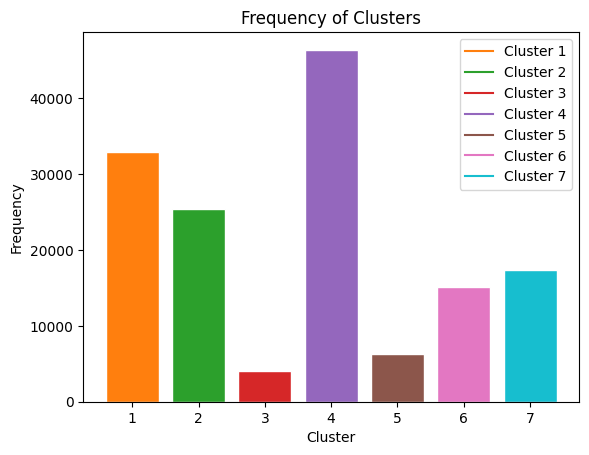

In [ ]:
from matplotlib.lines import Line2D

# Get the frequency counts for each cluster.
cluster_labels = [cluster_i + 1 for cluster_i in kmeans.labels_]
values, counts = np.unique(cluster_labels, return_counts=True)

# Set the colors for the barplot.
colors = ['tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:cyan']

# Plot the frequency of each cluster.
fig, ax = plt.subplots()
bars = ax.bar(values, counts, color=colors, edgecolor='white', linewidth=1)

# Create and plot a custom legend.
legend_elements = [Line2D([0], [0], color=colors[i], ls='-', label=f'Cluster {i + 1}') for i in range(0, num_clusters)]
plt.legend(handles=legend_elements, loc='upper right')

# Add the labels.
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Frequency of Clusters')

Since clusters 1 and 4, clusters 2 and 7, and clusters 3 and 5 are similar in nature, we can analyze the distribution of clusters with these pairs grouped together.

In [ ]:
# Clusters 1 and 4
print("Proportion of accidents in clusters 1 and 4:", (counts[0] + counts[3]) / counts.sum())

# Clusters 2 and 7
print("Proportion of accidents in clusters 2 and 7:", (counts[1] + counts[6]) / counts.sum())

# Clusters 3 and 5
print("Proportion of accidents in clusters 3 and 5:", (counts[2] + counts[4]) / counts.sum())

# Cluster 6
print("Proportion of accidents in cluster 6:", counts[5] / counts.sum())

Proportion of accidents in clusters 1 and 4: 0.537633168998325
Proportion of accidents in clusters 2 and 7: 0.28980829089330884
Proportion of accidents in clusters 3 and 5: 0.07025491140150411
Proportion of accidents in cluster 6: 0.10230362870686206


Since clusters 1 and 4 comprise over 53.76% and clusters 2 and 7 comprise of 28.98% of the reported traffic accidents (82.74%), we can focus on the following two groups:

Group 1 (clusters 1 and 4): More serious, more common collisions at moderate to high speeds (35-45mph). These patterns suggest crashes on high-volume main roads, including a mix of intersections and traffic controls. Disabling vehicle damage is also most common.

Group 2 (clusters 2 and 7): Relatively moderate accidents in slower settings (25-30mph). Possibly suburban main streets or neighborhood connectors due to the consistent speed limits and variety of crash controls. Majority of accidents were at places with no traffic controls. Disabling vehicle damage is most common.

<a name="Insights-and-Conclusions"></a>
# 7. Insights and Conclusions ✨

Throughout this project, we have followed the data science life cycle to bring reasonable insights into traffic accidents in Montgomery County, Maryland. After data processing, exploratory data analysis, hypothesis testing, and machine learning and analysis, we have a few conclusions we can make:

1) A significantly higher proportion of accidents that incur disabling damage to a vehicle happen when there is precipitation as compared to when the weather is clear.

2) Accidents that happen in a darker light level are proportionally more severe than those that happen during the day.

3) Machine learning analysis shows that the accidents in roads with higher speeds and high vehicular damage with new vehicles are increasing over time.

4) Machine learning analysis shows that clusters 2 and 7 (approximately 29% of the data) deal with low-speed accidents with a lack of traffic controls, which likely include suburban main streets or neighborhood connectors.

For the reader, this means that it is safer to drive on roads when the weather is clear; only drive when the conditions are bad when it is absolutely necessary. Additionally, be more attentive when the light levels are darker, as accidents are proportionally more common. Finally, the third and fourth points allude to a bigger issue - as the frequency of the accidents described in the third point increase, it is important for lawmakers to understand what type of roads these accidents happen on and change the appropriate road laws for increased human safety. Furthermore, the fourth point can justify a policy change to implement more traffic controls at the locations of these accidents, such as suburban streets or neighborhood connectors, to enforce lower speed limits. Additional controls such as speed cameras and fines for violators might also be helpful.

One issue in our data processing could have been that we removed too much of the data (we removed 18%), which could have led to skewed results. Additionally, some other reasons our data could have been skewed include potential problems with the feature encoding and some noise due to too many features (curse of dimensionality 👻).

Let's **speed** up the progress to safety and **drive** down accidents with the power of machine learning! 🏎️💨

